In [1]:
import numpy as np

In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import torch  # Используем в основном для загрузки MNIST и как эталон (если нужны тесты)
import torch.nn.functional as F  # Иногда полезен для сравнения или F.pad
import unittest
import math
import pickle  # Для сохранения/загрузки модели
import os
from tqdm.notebook import tqdm  # Для прогресс-бара в jupyter/colab

# from tqdm import tqdm # Для обычного скрипта
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler  # Для регрессии

# Загрузка MNIST
try:
    from torchvision.datasets import MNIST
    from torchvision.transforms import ToTensor

    TORCHVISION_AVAILABLE = True
except ImportError:
    print("Warning: torchvision not found. MNIST dataset cannot be loaded.")
    TORCHVISION_AVAILABLE = False

**Module** is an abstract class which defines fundamental methods necessary for a training a neural network. You do not need to change anything here, just read the comments.

In [3]:
import numpy as np


class Module(object):
    """
    Базовый класс для всех нейронных сетевых модулей.
    """

    def __init__(self):
        self.output = None
        self.gradInput = None
        self.training = True

    def forward(self, input):
        """
        Выполняет прямой проход. Не переопределять, использовать updateOutput.
        """
        return self.updateOutput(input)

    def backward(self, input, gradOutput):
        """
        Выполняет обратный проход. Не переопределять, использовать updateGradInput и accGradParameters.
        """
        # Сначала вычисляем градиент по входу
        grad_input = self.updateGradInput(input, gradOutput)
        # Затем вычисляем и накапливаем градиенты по параметрам
        self.accGradParameters(input, gradOutput)
        # Возвращаем градиент по входу
        return grad_input

    def updateOutput(self, input):
        """
        Вычисляет выход модуля. Должен быть переопределен дочерними классами.
        Необходимо сохранить результат в self.output и вернуть его.
        """
        # Пример:
        # self.output = input
        # return self.output
        raise NotImplementedError

    def updateGradInput(self, input, gradOutput):
        """
        Вычисляет градиент функции потерь по отношению ко входу модуля.
        Должен быть переопределен дочерними классами.
        Необходимо сохранить результат в self.gradInput и вернуть его.
        """
        # Пример:
        # self.gradInput = gradOutput
        # return self.gradInput
        raise NotImplementedError

    def accGradParameters(self, input, gradOutput):
        """
        Вычисляет градиент функции потерь по отношению к обучаемым параметрам модуля
        и *накапливает* его. Должен быть переопределен, если у модуля есть параметры.
        """
        # Ничего не делаем по умолчанию (для слоев без параметров)
        pass

    def zeroGradParameters(self):
        """
        Обнуляет накопленные градиенты параметров.
        Должен быть переопределен, если у модуля есть параметры.
        """
        # Ничего не делаем по умолчанию
        pass

    def getParameters(self):
        """
        Возвращает список обучаемых параметров модуля.
        """
        return []

    def getGradParameters(self):
        """
        Возвращает список градиентов по обучаемым параметрам.
        Порядок должен соответствовать getParameters().
        """
        return []

    def train(self):
        """
        Переключает модуль в режим обучения.
        """
        self.training = True

    def evaluate(self):
        """
        Переключает модуль в режим оценки.
        """
        self.training = False

    def __repr__(self):
        """с
        Возвращает строковое представление модуля.
        """
        return self.__class__.__name__ + "()"

# Sequential container

**Define** a forward and backward pass procedures.

In [4]:
class Sequential(Module):
    """Контейнер для последовательного применения модулей."""

    def __init__(self):
        super(Sequential, self).__init__()
        self.modules = []

    def add(self, module):
        self.modules.append(module)

    def updateOutput(self, input):
        current_output = input
        if not self.modules:
            self.output = current_output
            return self.output
        for module in self.modules:
            current_output = module.forward(current_output)
        self.output = current_output
        return self.output

    def backward(self, input, gradOutput):
        current_grad = gradOutput
        if not self.modules:
            self.gradInput = current_grad
            return self.gradInput
        for i in range(len(self.modules) - 1, -1, -1):
            module = self.modules[i]
            input_for_backward = input if i == 0 else self.modules[i - 1].output
            current_grad = module.backward(input_for_backward, current_grad)
        self.gradInput = current_grad
        return self.gradInput

    def zeroGradParameters(self):
        for module in self.modules:
            module.zeroGradParameters()

    def getParameters(self):
        params = []
        for module in self.modules:
            module_params = module.getParameters()
            # Важно: getParameters() может вернуть []
            if module_params:  # Проверяем, что список не пустой
                params.extend(module_params)
        return params

    def getGradParameters(self):
        grad_params = []
        for module in self.modules:
            module_grad_params = module.getGradParameters()
            if module_grad_params:  # Проверяем, что список не пустой
                grad_params.extend(module_grad_params)
        return grad_params

    def train(self):
        self.training = True
        for module in self.modules:
            module.train()

    def evaluate(self):
        self.training = False
        for module in self.modules:
            module.evaluate()

    def __repr__(self):
        string = "Sequential (\n"
        for i, module in enumerate(self.modules):
            module_str = str(module)
            indented_module_str = "  " + module_str.replace("\n", "\n  ")
            if indented_module_str.endswith("\n  "):
                indented_module_str = indented_module_str[:-2]
            string += f"  ({i}): {indented_module_str}\n"
        string += ")"
        return string

    def __getitem__(self, x):
        return self.modules.__getitem__(x)

# Layers

## 1 (0.2). Linear transform layer
Also known as dense layer, fully-connected layer, FC-layer, InnerProductLayer (in caffe), affine transform
- input:   **`batch_size x n_feats1`**
- output: **`batch_size x n_feats2`**

In [5]:
class Linear(Module):
    """Полносвязный слой."""

    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
        stdv = 1.0 / np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_out, n_in))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def updateOutput(self, input):
        self.output = input @ self.W.T + self.b
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput @ self.W
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        self.gradW += gradOutput.T @ input
        self.gradb += np.sum(gradOutput, axis=0)

    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)

    def getParameters(self):
        return [self.W, self.b]

    def getGradParameters(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        return f"Linear(in={self.W.shape[1]}, out={self.W.shape[0]})"

## 2. (0.2) SoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{softmax}(x)_i = \frac{\exp x_i} {\sum_j \exp x_j}$

Recall that $\text{softmax}(x) == \text{softmax}(x - \text{const})$. It makes possible to avoid computing exp() from large argument.

In [6]:
class SoftMax(Module):
    """SoftMax activation function."""

    def __init__(self):
        super(SoftMax, self).__init__()

    def updateOutput(self, input):
        stable_input = np.subtract(input, input.max(axis=1, keepdims=True))
        exp_output = np.exp(stable_input)
        sum_exp = np.sum(exp_output, axis=1, keepdims=True)
        # Добавим маленький эпсилон к знаменателю для дополнительной стабильности
        self.output = exp_output / (sum_exp + 1e-15)
        return self.output

    def updateGradInput(self, input, gradOutput):
        if self.output is None:
            raise ValueError("Output is not computed. Run forward pass first.")
        dot_product = np.sum(gradOutput * self.output, axis=1, keepdims=True)
        self.gradInput = self.output * (gradOutput - dot_product)
        return self.gradInput

    def __repr__(self):
        return "SoftMax()"  # Изменено для соответствия имени класса

## 3. (0.2) LogSoftMax
- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

$\text{logsoftmax}(x)_i = \log\text{softmax}(x)_i = x_i - \log {\sum_j \exp x_j}$

The main goal of this layer is to be used in computation of log-likelihood loss.

In [7]:
class LogSoftMax(Module):
    """LogSoftMax activation function."""

    def __init__(self):
        super(LogSoftMax, self).__init__()

    def updateOutput(self, input):
        stable_input = np.subtract(input, input.max(axis=1, keepdims=True))
        exp_stable = np.exp(stable_input)
        sum_exp_stable = np.sum(exp_stable, axis=1, keepdims=True)
        # Добавим эпсилон перед логарифмом
        log_sum_exp = np.log(sum_exp_stable + 1e-15)
        self.output = stable_input - log_sum_exp
        return self.output

    def updateGradInput(self, input, gradOutput):
        if self.output is None:
            raise ValueError("Output is not computed. Run forward pass first.")
        softmax_output = np.exp(self.output)
        sum_gradOutput = np.sum(gradOutput, axis=1, keepdims=True)
        self.gradInput = gradOutput - softmax_output * sum_gradOutput
        return self.gradInput

    def __repr__(self):
        return "LogSoftMax()"  # Исправлено имя для соответствия классу

## 4. (0.3) Batch normalization
One of the most significant recent ideas that impacted NNs a lot is [**Batch normalization**](http://arxiv.org/abs/1502.03167). The idea is simple, yet effective: the features should be whitened ($mean = 0$, $std = 1$) all the way through NN. This improves the convergence for deep models letting it train them for days but not weeks. **You are** to implement the first part of the layer: features normalization. The second part (`ChannelwiseScaling` layer) is implemented below.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

The layer should work as follows. While training (`self.training == True`) it transforms input as $$y = \frac{x - \mu}  {\sqrt{\sigma + \epsilon}}$$
where $\mu$ and $\sigma$ - mean and variance of feature values in **batch** and $\epsilon$ is just a small number for numericall stability. Also during training, layer should maintain exponential moving average values for mean and variance:
```
    self.moving_mean = self.moving_mean * alpha + batch_mean * (1 - alpha)
    self.moving_variance = self.moving_variance * alpha + batch_variance * (1 - alpha)
```
During testing (`self.training == False`) the layer normalizes input using moving_mean and moving_variance.

Note that decomposition of batch normalization on normalization itself and channelwise scaling here is just a common **implementation** choice. In general "batch normalization" always assumes normalization + scaling.

In [8]:
class BatchNormalization(Module):
    """Batch Normalization layer (без обучаемых gamma/beta)."""

    EPS = 1e-5  # Стандартный EPS для BN в PyTorch

    def __init__(self, alpha=0.9):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        self.moving_mean = None
        self.moving_variance = None
        # Статистики и промежуточные значения текущего батча (только для train)
        self.batch_mean = None
        self.batch_variance = None
        self.input_normalized = None
        self.inv_std = None
        self.input_shape = None

    def updateOutput(self, input):
        input_dtype = input.dtype
        input = input.astype(np.float64)  # Работаем с float64
        self.input_shape = input.shape
        if len(input.shape) != 2:
            raise ValueError(
                f"BatchNormalization expects 2D input (batch, features), got {input.shape}"
            )
        N, n_features = self.input_shape

        if self.training:
            if N == 1:
                # BN с батчем 1 в режиме train не имеет смысла, но PyTorch его обрабатывает,
                # используя moving average. Для простоты вернем 0 или вход.
                # Или можно использовать moving stats, если они есть
                print(
                    "Warning: BatchNormalization received batch size 1 in training mode."
                )
                if self.moving_mean is not None and self.moving_variance is not None:
                    # Используем moving stats как в eval режиме
                    inv_std_eval = 1.0 / np.sqrt(self.moving_variance + self.EPS)
                    self.output = (input - self.moving_mean) * inv_std_eval
                    # Не сохраняем batch stats и не обновляем moving stats
                    self.batch_mean = None
                    self.batch_variance = None
                    self.inv_std = None
                    self.input_normalized = None
                    return self.output.astype(input_dtype)
                else:  # Если и moving stats нет - возвращаем нули или вход
                    self.output = np.zeros_like(input)  # или input
                    return self.output.astype(input_dtype)

            # Стандартный расчет для N > 1
            self.batch_mean = np.mean(input, axis=0, keepdims=True)
            # Используем ddof=0 для biased variance
            self.batch_variance = np.var(input, axis=0, ddof=0, keepdims=True)

            # --- ИСПРАВЛЕНИЕ ИНИЦИАЛИЗАЦИИ/ОБНОВЛЕНИЯ ---
            if self.moving_mean is None:
                # ПЕРВЫЙ forward: Просто инициализируем статистики батча
                # (unbiased variance для moving_variance)
                self.moving_mean = self.batch_mean.copy()
                # PyTorch использует unbiased оценку для running_var
                unbiased_batch_variance = self.batch_variance * (
                    N / max(1.0, N - 1.0)
                )  # Деление на N-1, защита от N=1
                self.moving_variance = unbiased_batch_variance.copy()
            else:
                # ПОСЛЕДУЮЩИЕ forward: Обновляем по формуле
                self.moving_mean = (
                    self.alpha * self.moving_mean + (1.0 - self.alpha) * self.batch_mean
                )
                unbiased_batch_variance = self.batch_variance * (N / max(1.0, N - 1.0))
                self.moving_variance = (
                    self.alpha * self.moving_variance
                    + (1.0 - self.alpha) * unbiased_batch_variance
                )
            # ------------------------------------------

            # Нормализация и сохранение для backward (используем biased variance батча)
            self.inv_std = 1.0 / np.sqrt(self.batch_variance + self.EPS)
            self.input_normalized = (input - self.batch_mean) * self.inv_std
            self.output = self.input_normalized

        else:  # Режим оценки
            if self.moving_mean is None or self.moving_variance is None:
                # Если не тренировали, инициализируем стандартно
                print(
                    "Warning: BN in eval mode without training. Using default stats (mean=0, var=1)."
                )
                self.moving_mean = np.zeros((1, n_features))
                self.moving_variance = np.ones((1, n_features))

            inv_std_eval = 1.0 / np.sqrt(self.moving_variance + self.EPS)
            self.output = (input - self.moving_mean) * inv_std_eval
            # Не сохраняем batch stats в eval
            self.batch_mean = None
            self.batch_variance = None
            self.inv_std = None
            self.input_normalized = None

        return self.output.astype(input_dtype)

    def updateGradInput(self, input, gradOutput):
        input_dtype = input.dtype
        gradOutput = gradOutput.astype(np.float64)
        input = input.astype(np.float64)  # Input нужен для backward в train

        if not self.training:
            # Backward в eval - используем moving stats
            if self.moving_variance is None:
                # Если нет moving stats, градиент не определен корректно
                print(
                    "Warning: BN backward called in eval mode without stats. Returning zero grad."
                )
                self.gradInput = np.zeros_like(input)
                return self.gradInput.astype(input_dtype)

            inv_std_eval = 1.0 / np.sqrt(self.moving_variance + self.EPS)
            self.gradInput = gradOutput * inv_std_eval
            return self.gradInput.astype(input_dtype)

        # Только для режима обучения (использует сохраненные batch stats)
        if (
            self.input_shape is None
            or self.batch_mean is None
            or self.input_normalized is None
            or self.inv_std is None
        ):
            raise RuntimeError(
                "Backward pass called in train mode without prior training forward pass or with batch_size=1."
            )

        N = self.input_shape[0]
        if N == 1:  # Градиент не определен для N=1 в train
            print(
                "Warning: BN backward called in train mode with batch_size=1. Returning zero grad."
            )
            self.gradInput = np.zeros_like(input)
            return self.gradInput.astype(input_dtype)

        gradOutput_sum = np.sum(gradOutput, axis=0, keepdims=True)
        gradOutput_x_output_sum = np.sum(
            gradOutput * self.input_normalized, axis=0, keepdims=True
        )

        self.gradInput = (
            (1.0 / N)
            * self.inv_std
            * (
                N * gradOutput
                - gradOutput_sum
                - self.input_normalized * gradOutput_x_output_sum
            )
        )
        return self.gradInput.astype(input_dtype)

    def __repr__(self):
        n_feats = (
            self.moving_mean.shape[1] if self.moving_mean is not None else "Unknown"
        )
        return f"BatchNormalization(n_features={n_feats}, alpha={self.alpha})"

In [9]:
class ChannelwiseScaling(Module):
    """Применяет обучаемый масштаб и сдвиг по каналам."""

    def __init__(self, n_features):
        super(ChannelwiseScaling, self).__init__()
        self.gamma = np.ones(n_features)  # Веса (масштаб)
        self.beta = np.zeros(n_features)  # Смещения (сдвиг)
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)
        self.current_input = None  # Кэшируем вход для backward

    def updateOutput(self, input):
        if input.shape[-1] != self.gamma.shape[0]:
            raise ValueError(
                f"Input feature size {input.shape[-1]} != layer feature size {self.gamma.shape[0]}"
            )
        self.current_input = input
        # Broadcasting: (N, F) * (F,) + (F,) -> (N, F) или (N, C, H, W) * (C,) ...
        # Нужно, чтобы gamma/beta применялись к оси каналов/фичей (обычно ось 1 для Conv, ось -1 для Linear)
        # Сделаем универсальнее, предполагая, что последняя ось - фичи
        if input.ndim == 2:  # После Linear/Flatten
            self.output = self.gamma * input + self.beta
        elif input.ndim == 4:  # После Conv
            # gamma/beta shape (C,) -> reshape to (1, C, 1, 1) for broadcasting
            gamma_reshaped = self.gamma.reshape(1, -1, 1, 1)
            beta_reshaped = self.beta.reshape(1, -1, 1, 1)
            self.output = gamma_reshaped * input + beta_reshaped
        else:
            raise NotImplementedError("ChannelwiseScaling only supports 2D or 4D input")

        return self.output

    def updateGradInput(self, input, gradOutput):
        # dL/dInput = dL/dOutput * gamma
        if input.ndim == 2:
            self.gradInput = gradOutput * self.gamma
        elif input.ndim == 4:
            gamma_reshaped = self.gamma.reshape(1, -1, 1, 1)
            self.gradInput = gradOutput * gamma_reshaped
        else:  # Должно совпадать с updateOutput
            raise NotImplementedError(
                "ChannelwiseScaling only supports 2D or 4D input for backward"
            )
        return self.gradInput

    def accGradParameters(self, input, gradOutput):
        if self.current_input is None:
            raise RuntimeError("Need to run forward pass before accGradParameters.")
        # dL/dGamma = sum(dL/dOutput * input) по не-фичевым осям
        # dL/dBeta = sum(dL/dOutput) по не-фичевым осям
        if self.current_input.ndim == 2:
            axis_to_sum = (0,)
        elif self.current_input.ndim == 4:
            axis_to_sum = (0, 2, 3)
        else:  # Должно совпадать с updateOutput
            raise NotImplementedError(
                "ChannelwiseScaling only supports 2D or 4D input for accGrad"
            )

        self.gradGamma += np.sum(gradOutput * self.current_input, axis=axis_to_sum)
        self.gradBeta += np.sum(gradOutput, axis=axis_to_sum)

    def zeroGradParameters(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)

    def getParameters(self):
        return [self.gamma, self.beta]

    def getGradParameters(self):
        return [self.gradGamma, self.gradBeta]

    def __repr__(self):
        return f"ChannelwiseScaling(n_features={self.gamma.shape[0]})"

Practical notes. If BatchNormalization is placed after a linear transformation layer (including dense layer, convolutions, channelwise scaling) that implements function like `y = weight * x + bias`, than bias adding become useless and could be omitted since its effect will be discarded while batch mean subtraction. If BatchNormalization (followed by `ChannelwiseScaling`) is placed before a layer that propagates scale (including ReLU, LeakyReLU) followed by any linear transformation layer than parameter `gamma` in `ChannelwiseScaling` could be freezed since it could be absorbed into the linear transformation layer.

## 5. (0.3) Dropout
Implement [**dropout**](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf). The idea and implementation is really simple: just multimply the input by $Bernoulli(p)$ mask. Here $p$ is probability of an element to be zeroed.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons.

While training (`self.training == True`) it should sample a mask on each iteration (for every batch), zero out elements and multiply elements by $1 / (1 - p)$. The latter is needed for keeping mean values of features close to mean values which will be in test mode. When testing this module should implement identity transform i.e. `self.output = input`.

- input:   **`batch_size x n_feats`**
- output: **`batch_size x n_feats`**

In [10]:
class Dropout(Module):
    """Dropout layer."""

    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        if not (0.0 <= p < 1.0):
            raise ValueError("Dropout probability p must be in range [0, 1)")
        self.p = p  # Вероятность зануления
        self.mask = None

    def updateOutput(self, input):
        if self.training:
            # Вероятность СОХРАНЕНИЯ элемента = 1 - p
            self.mask = np.random.binomial(
                n=1, p=(1.0 - self.p), size=input.shape
            ).astype(input.dtype)
            # Масштабирование (inverted dropout)
            scale_factor = (
                1.0 / (1.0 - self.p) if self.p < 1.0 else 0.0
            )  # Деление на ноль если p=1
            self.output = input * self.mask * scale_factor
        else:
            self.output = input
            self.mask = None  # Не нужна в режиме eval
        return self.output

    def updateGradInput(self, input, gradOutput):
        if self.training:
            if self.mask is None:
                raise RuntimeError(
                    "Dropout mask is not available. Run forward pass in training mode first."
                )
            scale_factor = 1.0 / (1.0 - self.p) if self.p < 1.0 else 0.0
            self.gradInput = gradOutput * self.mask * scale_factor
        else:
            self.gradInput = gradOutput
        return self.gradInput

    def __repr__(self):
        return f"Dropout(p={self.p})"

# 6. (2.0) Conv2d
Implement [**Conv2d**](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Use only this list of parameters: (in_channels, out_channels, kernel_size, stride, padding, bias, padding_mode) and fix dilation=1 and groups=1.

In [11]:
def _pair(x, name="parameter"):
    if isinstance(x, int):
        return (x, x)
    if isinstance(x, tuple) and len(x) == 2 and all(isinstance(i, int) for i in x):
        return x
    raise ValueError(f"{name} must be int or tuple of 2 ints, but got {x}")


def _calculate_same_padding(input_size, kernel_size, stride):
    output_size = (input_size + stride - 1) // stride
    total_padding = max(0, (output_size - 1) * stride + kernel_size - input_size)
    pad_before = total_padding // 2
    pad_after = total_padding - pad_before
    return pad_before, pad_after


def get_im2col_indices(
    x_shape, kernel_h, kernel_w, stride_h, stride_w, pad_h_total, pad_w_total
):
    N, C, H, W = x_shape
    out_height = (H + pad_h_total - kernel_h) // stride_h + 1
    out_width = (W + pad_w_total - kernel_w) // stride_w + 1
    if out_height <= 0 or out_width <= 0:
        raise ValueError(f"Output size non-positive H={out_height}, W={out_width}")
    i0 = np.tile(np.repeat(np.arange(kernel_h), kernel_w), C)
    j0 = np.tile(np.tile(np.arange(kernel_w), kernel_h), C)
    i1 = stride_h * np.repeat(np.arange(out_height), out_width)
    j1 = stride_w * np.tile(np.arange(out_width), out_height)
    i = i0[:, None] + i1[None, :]
    j = j0[:, None] + j1[None, :]
    k = np.repeat(np.arange(C), kernel_h * kernel_w)
    return k.astype(int), i.astype(int), j.astype(int), out_height, out_width


def im2col_indices(x, kernel_h, kernel_w, stride_h, stride_w, pad_tuple, padding_mode):
    N, C, H, W = x.shape
    pad_top, pad_bottom, pad_left, pad_right = pad_tuple
    pad_h_total = pad_top + pad_bottom
    pad_w_total = pad_left + pad_right
    if pad_h_total > 0 or pad_w_total > 0:
        np_pad_width = ((0, 0), (0, 0), (pad_top, pad_bottom), (pad_left, pad_right))
        mode_map = {"zeros": "constant", "reflect": "reflect", "replicate": "edge"}
        if padding_mode not in mode_map:
            raise ValueError(f"Unsupported padding: {padding_mode}")
        x_padded = np.pad(
            x,
            np_pad_width,
            mode=mode_map[padding_mode],
            **({"constant_values": 0} if padding_mode == "zeros" else {}),
        )
    else:
        x_padded = x
    k, i_rel_padded, j_rel_padded, H_out, W_out = get_im2col_indices(
        x.shape, kernel_h, kernel_w, stride_h, stride_w, pad_h_total, pad_w_total
    )
    cols = x_padded[:, k[:, None], i_rel_padded, j_rel_padded]
    cols = cols.transpose(1, 0, 2).reshape(C * kernel_h * kernel_w, N * H_out * W_out)
    output_shape_info = (N, -1, H_out, W_out)
    return cols, output_shape_info


def col2im_indices(cols, x_shape, kernel_h, kernel_w, stride_h, stride_w, pad_tuple):
    N, C, H, W = x_shape
    pad_top, pad_bottom, pad_left, pad_right = pad_tuple
    pad_h_total = pad_top + pad_bottom
    pad_w_total = pad_left + pad_right
    H_padded = H + pad_h_total
    W_padded = W + pad_w_total
    k, i_rel_padded, j_rel_padded, H_out, W_out = get_im2col_indices(
        x_shape, kernel_h, kernel_w, stride_h, stride_w, pad_h_total, pad_w_total
    )
    x_padded_grad = np.zeros((N, C, H_padded, W_padded), dtype=cols.dtype)
    cols_reshaped = cols.reshape(C * kernel_h * kernel_w, N, H_out * W_out).transpose(
        1, 0, 2
    )
    idx_n = np.arange(N)[:, None, None]
    np.add.at(
        x_padded_grad,
        (idx_n, k[None, :, None], i_rel_padded[None, :, :], j_rel_padded[None, :, :]),
        cols_reshaped,
    )
    if pad_h_total == 0 and pad_w_total == 0:
        return x_padded_grad
    else:
        return x_padded_grad[
            :, :, pad_top : H_padded - pad_bottom, pad_left : W_padded - pad_right
        ]

In [12]:
class Conv2d(Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        bias=True,
        padding_mode="zeros",
    ):
        super(Conv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = _pair(kernel_size)
        self.stride = _pair(stride)
        self.padding_arg = padding
        self.use_bias = bias
        if padding_mode not in ["zeros", "reflect", "replicate"]:
            raise ValueError(f"Unsupported padding_mode: {padding_mode}")
        self.padding_mode = padding_mode
        fan_in = self.in_channels * self.kernel_size[0] * self.kernel_size[1]
        bound = np.sqrt(6.0 / fan_in) if fan_in > 0 else 0
        self.W = np.random.uniform(
            -bound,
            bound,
            (out_channels, in_channels, self.kernel_size[0], self.kernel_size[1]),
        ).astype(np.float64)
        self.gradW = np.zeros_like(self.W)
        if self.use_bias:
            bound_b = 1.0 / np.sqrt(fan_in) if fan_in > 0 else 0
            self.b = np.random.uniform(-bound_b, bound_b, out_channels).astype(
                np.float64
            )
            self.gradB = np.zeros_like(self.b)
        else:
            self.b = None
            self.gradB = None
        self.input_shape = None
        self.cols = None
        self.calculated_padding_tuple = None
        self.output_shape_info = None
        # Добавим атрибуты weight/bias для совместимости с кодом теста
        self.weight = self.W
        self.bias = self.b

    def _resolve_padding(self, H_in, W_in):
        KH, KW = self.kernel_size
        SH, SW = self.stride
        if isinstance(self.padding_arg, str):
            pad_str = self.padding_arg.lower()
            pt, pb, pl, pr = 0, 0, 0, 0
            if pad_str == "valid":
                pass
            elif pad_str == "same":
                pt, pb = _calculate_same_padding(H_in, KH, SH)
                pl, pr = _calculate_same_padding(W_in, KW, SW)
            else:
                raise ValueError(f"Unknown padding string: {self.padding_arg}")
            return (pt, pb, pl, pr)
        else:
            PH, PW = _pair(self.padding_arg)
            return (PH, PH, PW, PW)

    def updateOutput(self, input):
        input_dtype = input.dtype
        input_f64 = input.astype(np.float64, copy=False)
        self.input_shape = input.shape
        N, C_in, H_in, W_in = self.input_shape
        KH, KW = self.kernel_size
        SH, SW = self.stride
        if C_in != self.in_channels:
            raise ValueError("Input channel mismatch")
        self.calculated_padding_tuple = self._resolve_padding(H_in, W_in)
        self.cols, self.output_shape_info = im2col_indices(
            input_f64, KH, KW, SH, SW, self.calculated_padding_tuple, self.padding_mode
        )
        W_flat = self.W.reshape(self.out_channels, -1)
        result = W_flat @ self.cols
        if self.use_bias:
            result += self.b.reshape(-1, 1)
        N_out, _, H_out, W_out = self.output_shape_info
        try:
            self.output = result.reshape(
                self.out_channels, N_out, H_out, W_out
            ).transpose(1, 0, 2, 3)
        except ValueError as e:
            raise ValueError(f"Output reshape error: {e}")
        return self.output.astype(input_dtype)

    def updateGradInput(self, input, gradOutput):
        input_dtype = input.dtype
        gradOutput_f64 = gradOutput.astype(np.float64, copy=False)
        if self.input_shape is None or self.calculated_padding_tuple is None:
            raise RuntimeError("Need forward pass")
        N, C_out, H_out, W_out = gradOutput.shape
        KH, KW = self.kernel_size
        SH, SW = self.stride
        gradOutput_flat = gradOutput_f64.transpose(1, 0, 2, 3).reshape(
            self.out_channels, -1
        )
        W_flat = self.W.reshape(self.out_channels, -1)
        grad_cols = W_flat.T @ gradOutput_flat
        self.gradInput = col2im_indices(
            grad_cols, self.input_shape, KH, KW, SH, SW, self.calculated_padding_tuple
        )
        return self.gradInput.astype(input_dtype)

    def accGradParameters(self, input, gradOutput):
        gradOutput_f64 = gradOutput.astype(np.float64, copy=False)
        if self.cols is None:
            raise RuntimeError("Need forward pass")
        N, C_out, H_out, W_out = gradOutput.shape
        KH, KW = self.kernel_size
        if self.use_bias:  # Исправлено
            if self.gradB is None:
                raise RuntimeError("gradB missing")
            self.gradB += np.sum(gradOutput_f64, axis=(0, 2, 3))
        if self.gradW is None:
            raise RuntimeError("gradW missing")
        gradOutput_flat = gradOutput_f64.transpose(1, 0, 2, 3).reshape(
            self.out_channels, -1
        )
        gradW_flat = gradOutput_flat @ self.cols.T
        self.gradW += gradW_flat.reshape(self.W.shape)

    def zeroGradParameters(self):
        if hasattr(self, "gradW") and self.gradW is not None:
            self.gradW.fill(0)
        if self.use_bias and hasattr(self, "gradB") and self.gradB is not None:
            self.gradB.fill(0)

    def getParameters(self):
        return [self.W, self.b] if self.use_bias else [self.W]

    def getGradParameters(self):
        return [self.gradW, self.gradB] if self.use_bias else [self.gradW]

    def __repr__(self):  # Исправлено
        s = f"Conv2d({self.in_channels},{self.out_channels},K={self.kernel_size},S={self.stride},P={self.padding_arg}"
        if self.padding_mode != "zeros":
            s += f",mode={self.padding_mode}"
        if not self.use_bias:
            s += ",bias=False"
        return s + ")"

#7. (0.5) Implement [**MaxPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) and [**AvgPool2d**](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html). Use only parameters like kernel_size, stride, padding (negative infinity for maxpool and zero for avgpool) and other parameters fixed as in framework.

In [13]:
# --- MaxPool2d (Исправленный) ---
class MaxPool2d(Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(MaxPool2d, self).__init__()
        self.kernel_size = _pair(kernel_size, "kernel_size")
        self.stride = _pair(stride if stride is not None else kernel_size, "stride")
        # --- ИЗМЕНЕНИЕ: Сохраняем padding как аргумент для _resolve_padding ---
        # self.padding = _pair(padding, "padding") # Старое
        self.padding_arg = padding  # Новое имя для аргумента

        if any(s > k for s, k in zip(self.stride, self.kernel_size)):
            print(
                f"Warning: MaxPool2d stride {self.stride} > kernel_size {self.kernel_size}. This is unusual."
            )
        self.max_indices = None  # Индексы максимумов
        self.input_shape = None
        self.calculated_padding_tuple = None  # Кэшируем кортеж паддинга

    # --- ДОБАВЛЕНО: Метод для вычисления кортежа паддинга (как в Conv2d) ---
    #     (Предполагаем, что MaxPool не поддерживает 'same'/'valid' строки, только числа)
    def _resolve_padding(self, H_in, W_in):
        """Вычисляет (top, bottom, left, right) паддинг для MaxPool."""
        # MaxPool обычно использует только числовой паддинг
        try:
            PH, PW = _pair(self.padding_arg, "padding")
            return (PH, PH, PW, PW)  # Симметричный паддинг
        except ValueError:
            raise ValueError(
                f"MaxPool2d padding must be int or tuple of 2 ints, got {self.padding_arg}"
            )

    def updateOutput(self, input):
        input_dtype = input.dtype
        input_f64 = input.astype(np.float64, copy=False)  # Используем float64
        self.input_shape = input.shape
        N, C, H_in, W_in = self.input_shape
        KH, KW = self.kernel_size
        SH, SW = self.stride
        # --- ИЗМЕНЕНИЕ: Вычисляем и кэшируем кортеж паддинга ---
        self.calculated_padding_tuple = self._resolve_padding(H_in, W_in)
        pad_top, pad_bottom, pad_left, pad_right = self.calculated_padding_tuple
        pad_h_total = pad_top + pad_bottom
        pad_w_total = pad_left + pad_right
        # -------------------------------------------------------

        H_out = (H_in + pad_h_total - KH) // SH + 1  # Используем общие отступы
        W_out = (W_in + pad_w_total - KW) // SW + 1
        if H_out <= 0 or W_out <= 0:
            raise ValueError(f"Output size non-positive ({H_out}x{W_out})")

        # --- ИЗМЕНЕНИЕ: Правильный вызов im2col_indices ---
        # MaxPool требует паддинг -inf, НО НАША im2col/col2im это пока не поддерживают.
        # Используем 'zeros' временно, чтобы исправить TypeError.
        # Для полной корректности MaxPool с паддингом нужна доработка im2col/col2im.
        current_padding_mode = "zeros"
        cols, _ = im2col_indices(  # Используем _ чтобы игнорировать output_shape_info
            input_f64,
            KH,
            KW,
            SH,
            SW,
            pad_tuple=self.calculated_padding_tuple,  # Передаем кортеж
            padding_mode=current_padding_mode,  # Передаем режим
        )
        # --- КОНЕЦ ИЗМЕНЕНИЯ ---

        cols_reshaped = cols.reshape(C, KH * KW, -1)
        max_vals = np.max(cols_reshaped, axis=1)
        self.max_indices = np.argmax(cols_reshaped, axis=1)

        try:
            self.output = max_vals.reshape(C, N, H_out, W_out).transpose(1, 0, 2, 3)
        except ValueError as e:
            raise ValueError(f"MaxPool2d reshape error: {e}")

        return self.output.astype(input_dtype)  # Возвращаем исходный тип

    def updateGradInput(self, input, gradOutput):
        input_dtype = input.dtype  # Сохраняем тип
        # Переводим gradOutput в float64 для вычислений
        gradOutput_f64 = gradOutput.astype(np.float64, copy=False)

        if (
            self.max_indices is None
            or self.input_shape is None
            or self.calculated_padding_tuple is None
        ):
            raise RuntimeError("Need forward pass first for MaxPool2d backward.")
        N, C, H_in, W_in = self.input_shape
        KH, KW = self.kernel_size
        SH, SW = self.stride
        # PH, PW не нужны напрямую, используем calculated_padding_tuple
        _, _, H_out, W_out = gradOutput.shape

        grad_cols_shape = (C * KH * KW, N * H_out * W_out)
        grad_cols = np.zeros(
            grad_cols_shape, dtype=gradOutput_f64.dtype
        )  # Используем float64

        gradOutput_flat = gradOutput_f64.transpose(1, 0, 2, 3).reshape(C, -1)

        channel_offsets = np.arange(C)[:, None] * (KH * KW)
        row_indices = channel_offsets + self.max_indices  # Индексы строк в grad_cols

        col_indices = np.arange(N * H_out * W_out)[None, :]  # Индексы столбцов

        flat_row_indices = row_indices.ravel()
        flat_col_indices = np.tile(col_indices, (C, 1)).ravel()
        flat_gradOutput = gradOutput_flat.ravel()

        # Используем np.add.at (все вычисления в float64)
        np.add.at(grad_cols, (flat_row_indices, flat_col_indices), flat_gradOutput)

        # --- ИЗМЕНЕНИЕ: Правильный вызов col2im_indices ---
        self.gradInput = col2im_indices(
            grad_cols,
            self.input_shape,  # Оригинальная форма входа
            KH,
            KW,
            SH,
            SW,
            self.calculated_padding_tuple,  # Передаем сохраненный кортеж
        )
        # --- КОНЕЦ ИЗМЕНЕНИЯ ---
        return self.gradInput.astype(input_dtype)  # Возвращаем исходный тип

    def __repr__(self):
        # Используем self.padding_arg для отображения исходного значения
        return f"MaxPool2d(kernel_size={self.kernel_size}, stride={self.stride}, padding={self.padding_arg})"


# --- AvgPool2d (Исправленный) ---
class AvgPool2d(Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(AvgPool2d, self).__init__()
        self.kernel_size = _pair(kernel_size, "kernel_size")
        self.stride = _pair(stride if stride is not None else kernel_size, "stride")
        # --- ИЗМЕНЕНИЕ: Сохраняем padding как аргумент для _resolve_padding ---
        self.padding_arg = padding
        self.pool_size = self.kernel_size[0] * self.kernel_size[1]
        if self.pool_size == 0:
            raise ValueError("Pool size cannot be zero")
        self.input_shape = None
        self.calculated_padding_tuple = None  # Кэшируем кортеж паддинга

    # --- ДОБАВЛЕНО: Метод для вычисления кортежа паддинга ---
    def _resolve_padding(self, H_in, W_in):
        """Вычисляет (top, bottom, left, right) паддинг для AvgPool."""
        # AvgPool обычно использует только числовой паддинг
        try:
            PH, PW = _pair(self.padding_arg, "padding")
            return (PH, PH, PW, PW)  # Симметричный паддинг
        except ValueError:
            raise ValueError(
                f"AvgPool2d padding must be int or tuple of 2 ints, got {self.padding_arg}"
            )

    def updateOutput(self, input):
        input_dtype = input.dtype
        input_f64 = input.astype(np.float64, copy=False)  # Используем float64
        self.input_shape = input.shape
        N, C, H_in, W_in = self.input_shape
        KH, KW = self.kernel_size
        SH, SW = self.stride
        # --- ИЗМЕНЕНИЕ: Вычисляем и кэшируем кортеж паддинга ---
        self.calculated_padding_tuple = self._resolve_padding(H_in, W_in)
        pad_top, pad_bottom, pad_left, pad_right = self.calculated_padding_tuple
        pad_h_total = pad_top + pad_bottom
        pad_w_total = pad_left + pad_right
        # -------------------------------------------------------

        H_out = (H_in + pad_h_total - KH) // SH + 1
        W_out = (W_in + pad_w_total - KW) // SW + 1
        if H_out <= 0 or W_out <= 0:
            raise ValueError(f"Output size non-positive ({H_out}x{W_out})")

        # --- ИЗМЕНЕНИЕ: Правильный вызов im2col_indices ---
        current_padding_mode = "zeros"  # AvgPool всегда использует нули
        cols, _ = im2col_indices(  # Игнорируем output_shape_info
            input_f64,
            KH,
            KW,
            SH,
            SW,
            pad_tuple=self.calculated_padding_tuple,  # Передаем кортеж
            padding_mode=current_padding_mode,  # Передаем режим
        )
        # --- КОНЕЦ ИЗМЕНЕНИЯ ---

        cols_reshaped = cols.reshape(C, KH * KW, -1)
        avg_vals = np.mean(cols_reshaped, axis=1)  # Вычисления в float64

        try:
            self.output = avg_vals.reshape(C, N, H_out, W_out).transpose(1, 0, 2, 3)
        except ValueError as e:
            raise ValueError(f"AvgPool2d reshape error: {e}")

        return self.output.astype(input_dtype)  # Возвращаем исходный тип

    def updateGradInput(self, input, gradOutput):
        input_dtype = input.dtype  # Сохраняем тип
        gradOutput_f64 = gradOutput.astype(np.float64, copy=False)  # float64

        if self.input_shape is None or self.calculated_padding_tuple is None:
            raise RuntimeError("Need forward pass first.")
        N, C, H_in, W_in = self.input_shape
        KH, KW = self.kernel_size
        SH, SW = self.stride
        # PH, PW не нужны напрямую
        _, _, H_out, W_out = gradOutput.shape

        gradOutput_flat = gradOutput_f64.transpose(1, 0, 2, 3).reshape(C, -1)
        gradOutput_divided = gradOutput_flat / self.pool_size  # float64

        grad_cols_per_channel = np.repeat(
            gradOutput_divided[:, np.newaxis, :], KH * KW, axis=1
        )
        grad_cols = grad_cols_per_channel.reshape(C * KH * KW, -1)  # float64

        # --- ИЗМЕНЕНИЕ: Правильный вызов col2im_indices ---
        self.gradInput = col2im_indices(
            grad_cols,
            self.input_shape,
            KH,
            KW,
            SH,
            SW,
            self.calculated_padding_tuple,  # Передаем сохраненный кортеж
        )
        # --- КОНЕЦ ИЗМЕНЕНИЯ ---
        return self.gradInput.astype(input_dtype)  # Возвращаем исходный тип

    def __repr__(self):
        return f"AvgPool2d(kernel_size={self.kernel_size}, stride={self.stride}, padding={self.padding_arg})"

# 8. (0.3) Implement **GlobalMaxPool2d** and **GlobalAvgPool2d**. They do not have testing and parameters are up to you but they must aggregate information within channels. Write test functions for these layers on your own.

In [14]:
# --- GlobalMaxPool2d ---
class GlobalMaxPool2d(Module):
    """Глобальный Max Pooling."""

    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()
        self.input_shape = None
        self.max_indices_flat = None

    def updateOutput(self, input):
        self.input_shape = input.shape
        N, C, H, W = self.input_shape
        self.output = np.max(input, axis=(2, 3), keepdims=True)
        input_reshaped = input.reshape(N, C, H * W)
        self.max_indices_flat = np.argmax(input_reshaped, axis=2)  # (N, C)
        return self.output

    def updateGradInput(self, input, gradOutput):
        if self.input_shape is None or self.max_indices_flat is None:
            raise RuntimeError("Need forward pass first.")
        N, C, H, W = self.input_shape
        self.gradInput = np.zeros(self.input_shape, dtype=gradOutput.dtype)
        gradOutput_flat = gradOutput.reshape(N, C)
        idx_n, idx_c = np.meshgrid(np.arange(N), np.arange(C), indexing="ij")
        idx_h, idx_w = np.unravel_index(self.max_indices_flat, (H, W))
        self.gradInput[idx_n, idx_c, idx_h, idx_w] = gradOutput_flat
        return self.gradInput


class GlobalAvgPool2d(Module):
    """Глобальный Average Pooling."""

    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
        self.input_shape = None

    def updateOutput(self, input):
        self.input_shape = input.shape
        N, C, H, W = self.input_shape
        self.output = np.mean(input, axis=(2, 3), keepdims=True)
        return self.output

    def updateGradInput(self, input, gradOutput):
        if self.input_shape is None:
            raise RuntimeError("Need forward pass first.")
        N, C, H, W = self.input_shape
        pool_size = float(H * W)
        # Используем broadcasting
        self.gradInput = gradOutput / pool_size
        # Убедимся, что форма правильная после broadcasting
        if self.gradInput.shape != self.input_shape:
            self.gradInput = np.broadcast_to(self.gradInput, self.input_shape)
        return self.gradInput

    # Параметров нет


# --- Flatten ---
class Flatten(Module):
    """Слой "выпрямления" тензора."""

    def __init__(self, start_dim=1, end_dim=-1):
        super(Flatten, self).__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim
        self.original_shape = None

    def updateOutput(self, input):
        self.original_shape = input.shape
        n_dims = input.ndim
        actual_start_dim = (
            self.start_dim if self.start_dim >= 0 else n_dims + self.start_dim
        )
        actual_end_dim = self.end_dim if self.end_dim >= 0 else n_dims + self.end_dim

        if not (0 <= actual_start_dim < n_dims):
            raise IndexError("start_dim out of range")
        if not (0 <= actual_end_dim < n_dims):
            raise IndexError("end_dim out of range")
        if actual_start_dim > actual_end_dim:
            raise ValueError("start_dim must be <= end_dim")

        new_shape = list(self.original_shape[:actual_start_dim])
        flattened_dim = np.prod(
            self.original_shape[actual_start_dim : actual_end_dim + 1], dtype=int
        )
        new_shape.append(flattened_dim)
        new_shape.extend(self.original_shape[actual_end_dim + 1 :])

        self.output = input.reshape(tuple(new_shape))
        return self.output

    def updateGradInput(self, input, gradOutput):
        if self.original_shape is None:
            raise RuntimeError("Need forward pass first.")
        try:
            self.gradInput = gradOutput.reshape(self.original_shape)
        except ValueError as e:
            raise ValueError(
                f"Cannot reshape gradOutput {gradOutput.shape} to original {self.original_shape}. Error: {e}"
            )
        return self.gradInput

    def __repr__(self):
        return f"Flatten(start_dim={self.start_dim}, end_dim={self.end_dim})"

# 9. (0.2) Implement [**Flatten**](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [15]:
class Flatten(Module):
    """
    Преобразует многомерный вход в 2D тензор (или другую размерность,
    контролируемую start_dim и end_dim), объединяя указанный диапазон осей.
    """

    def __init__(self, start_dim=1, end_dim=-1):
        """
        Args:
            start_dim (int): Первая ось для "сплющивания". По умолчанию 1 (оставляя батч).
            end_dim (int): Последняя ось для "сплющивания". По умолчанию -1 (до конца).
        """
        super(Flatten, self).__init__()
        self.start_dim = start_dim
        self.end_dim = end_dim
        self.original_shape = None  # Сохраняем исходную форму для backward

    def updateOutput(self, input):
        """
        Выполняет forward pass.
        input shape: (d0, d1, ..., dn)
        output shape: (d0, ..., d_start-1, D, d_end+1, ..., dn), где D - произведение размеров
                      от start_dim до end_dim включительно.
        """
        self.original_shape = input.shape
        n_dims = input.ndim

        # Нормализуем индексы start_dim и end_dim
        actual_start_dim = (
            self.start_dim if self.start_dim >= 0 else n_dims + self.start_dim
        )
        actual_end_dim = self.end_dim if self.end_dim >= 0 else n_dims + self.end_dim

        if actual_start_dim < 0 or actual_start_dim >= n_dims:
            raise IndexError(
                f"start_dim {self.start_dim} out of range for input with {n_dims} dims"
            )
        if actual_end_dim < 0 or actual_end_dim >= n_dims:
            raise IndexError(
                f"end_dim {self.end_dim} out of range for input with {n_dims} dims"
            )
        if actual_start_dim > actual_end_dim:
            raise ValueError(
                f"start_dim ({actual_start_dim}) must be <= end_dim ({actual_end_dim})"
            )

        # Собираем новую форму
        new_shape = []
        # 1. Оси до start_dim
        new_shape.extend(self.original_shape[:actual_start_dim])
        # 2. "Сплющенная" ось (используем -1 для автоматического расчета)
        new_shape.append(-1)
        # 3. Оси после end_dim
        new_shape.extend(self.original_shape[actual_end_dim + 1 :])

        # Выполняем reshape
        self.output = input.reshape(tuple(new_shape))
        return self.output

    def updateGradInput(self, input, gradOutput):
        """
        Вычисляет градиент по входу. Это просто reshape обратно к исходной форме.
        gradOutput shape: (d0, ..., d_start-1, D, d_end+1, ..., dn)
        gradInput shape: (d0, d1, ..., dn) (исходная форма входа)
        """
        if self.original_shape is None:
            raise RuntimeError(
                "Need to run forward pass before backward to know the original shape."
            )

        # Просто меняем форму градиента обратно на исходную
        try:
            self.gradInput = gradOutput.reshape(self.original_shape)
        except ValueError as e:
            raise ValueError(
                f"Cannot reshape gradOutput shape {gradOutput.shape} "
                f"back to original input shape {self.original_shape}. Mismatched elements? Error: {e}"
            )

        return self.gradInput

    def __repr__(self):
        return f"Flatten(start_dim={self.start_dim}, end_dim={self.end_dim})"

# Activation functions

Here's the complete example for the **Rectified Linear Unit** non-linearity (aka **ReLU**):

In [16]:
class ReLU(Module):
    """Rectified Linear Unit."""

    def __init__(self):
        super(ReLU, self).__init__()

    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output

    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput, input > 0)
        return self.gradInput

    def __repr__(self):
        return "ReLU()"  # Добавим скобки для консистентности

## 10. (0.1) Leaky ReLU
Implement [**Leaky Rectified Linear Unit**](http://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29%23Leaky_ReLUs). Expriment with slope.

In [17]:
class LeakyReLU(Module):
    """Leaky Rectified Linear Unit."""

    def __init__(self, slope=0.01):
        super(LeakyReLU, self).__init__()
        if not isinstance(slope, (int, float)):
            raise TypeError("slope must be a number")
        self.slope = slope

    def updateOutput(self, input):
        self.output = np.where(input >= 0, input, self.slope * input)
        return self.output

    def updateGradInput(self, input, gradOutput):
        grad_mask = np.where(input >= 0, 1.0, self.slope)
        self.gradInput = gradOutput * grad_mask
        return self.gradInput

    def __repr__(self):
        return f"LeakyReLU(slope={self.slope})"

## 11. (0.1) ELU
Implement [**Exponential Linear Units**](http://arxiv.org/abs/1511.07289) activations.

In [18]:
class ELU(Module):
    """Exponential Linear Unit."""

    def __init__(self, alpha=1.0):
        super(ELU, self).__init__()
        if not isinstance(alpha, (int, float)) or alpha <= 0:
            raise ValueError("alpha must be a positive number")
        self.alpha = alpha

    def updateOutput(self, input):
        self.output = np.where(input >= 0, input, self.alpha * (np.exp(input) - 1.0))
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Используем более прямую форму производной
        grad_mask = np.where(input >= 0, 1.0, self.alpha * np.exp(input))
        self.gradInput = gradOutput * grad_mask
        return self.gradInput

    def __repr__(self):
        return f"ELU(alpha={self.alpha})"

## 12. (0.1) SoftPlus
Implement [**SoftPlus**](https://en.wikipedia.org/wiki%2FRectifier_%28neural_networks%29) activations. Look, how they look a lot like ReLU.

In [19]:
class SoftPlus(Module):
    """SoftPlus activation function."""

    def __init__(self):
        super(SoftPlus, self).__init__()

    def updateOutput(self, input):
        # Стабильная версия log(1 + exp(x))
        self.output = np.logaddexp(0, input)
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Производная = sigmoid(x)
        sigmoid_input = 1.0 / (1.0 + np.exp(-input))
        self.gradInput = gradOutput * sigmoid_input
        return self.gradInput

    def __repr__(self):
        return "SoftPlus()"  # Добавим скобки

#13. (0.2) Gelu
Implement [**Gelu**](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html) activations.

In [20]:
class Gelu(Module):
    """Gaussian Error Linear Unit (аппроксимация tanh)."""

    def __init__(self):
        super(Gelu, self).__init__()
        self.sqrt_2_div_pi = np.sqrt(2.0 / np.pi)
        self.coeff = 0.044715

    def _gelu_approx(self, x):
        inner = self.sqrt_2_div_pi * (x + self.coeff * np.power(x, 3))
        return 0.5 * x * (1.0 + np.tanh(inner))

    def _gelu_approx_derivative(self, x):
        inner = self.sqrt_2_div_pi * (x + self.coeff * np.power(x, 3))
        tanh_inner = np.tanh(inner)
        inner_derivative = self.sqrt_2_div_pi * (
            1.0 + 3.0 * self.coeff * np.power(x, 2)
        )
        # Производная от tanh(inner(x)) = sech^2(inner(x)) * inner'(x)
        tanh_derivative = (1.0 - np.power(tanh_inner, 2)) * inner_derivative
        # Производная от 0.5 * x * (1 + tanh(inner(x))) по правилу произведения f'g + fg'
        derivative = 0.5 * (1.0 + tanh_inner) + 0.5 * x * tanh_derivative
        return derivative

    def updateOutput(self, input):
        # Используем float64 для промежуточных вычислений tanh для точности
        input_f64 = input.astype(np.float64)
        self.output = self._gelu_approx(input_f64)
        return self.output.astype(input.dtype)  # Возвращаем исходный тип

    def updateGradInput(self, input, gradOutput):
        input_f64 = input.astype(np.float64)
        gelu_derivative = self._gelu_approx_derivative(input_f64)
        self.gradInput = gradOutput * gelu_derivative.astype(gradOutput.dtype)
        return self.gradInput

    def __repr__(self):
        return "Gelu()"

# Criterions

Criterions are used to score the models answers.

In [21]:
import numpy as np


class Criterion(object):
    """
    Базовый класс для функций потерь (критериев).
    """

    def __init__(self):
        self.output = None  # Значение функции потерь
        self.gradInput = None  # Градиент функции потерь по входу сети (y_pred)

    def forward(self, input, target):
        """
        Вычисляет значение функции потерь. Не переопределять, использовать updateOutput.
        """
        return self.updateOutput(input, target)

    def backward(self, input, target):
        """
        Вычисляет градиент функции потерь по входу сети. Не переопределять, использовать updateGradInput.
        """
        return self.updateGradInput(input, target)

    def updateOutput(self, input, target):
        """
        Вычисляет значение функции потерь. Должен быть переопределен.
        Необходимо сохранить результат в self.output и вернуть его.
        """
        raise NotImplementedError

    def updateGradInput(self, input, target):
        """
        Вычисляет градиент функции потерь по входу сети (input). Должен быть переопределен.
        Необходимо сохранить результат в self.gradInput и вернуть его.
        """
        raise NotImplementedError

    def __repr__(self):
        """
        Возвращает строковое представление критерия.
        """
        return self.__class__.__name__ + "()"

The **MSECriterion**, which is basic L2 norm usually used for regression, is implemented here for you.
- input:   **`batch_size x n_feats`**
- target: **`batch_size x n_feats`**
- output: **scalar**

In [22]:
class MSECriterion(Criterion):
    """Среднеквадратичная ошибка."""

    def __init__(self):
        super(MSECriterion, self).__init__()

    def updateOutput(self, input, target):
        if input.shape != target.shape:
            raise ValueError("Input and target shapes must match")
        sum_sq_diff = np.sum(np.power(input - target, 2))
        self.output = sum_sq_diff / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        if input.shape != target.shape:
            raise ValueError("Input and target shapes must match")
        self.gradInput = (input - target) * 2.0 / input.shape[0]
        return self.gradInput

    def __repr__(self):
        return "MSECriterion()"  # Добавим скобки

## 14. (0.2) Negative LogLikelihood criterion (numerically unstable)
You task is to implement the **ClassNLLCriterion**. It should implement [multiclass log loss](http://scikit-learn.org/stable/modules/model_evaluation.html#log-loss). Nevertheless there is a sum over `y` (target) in that formula,
remember that targets are one-hot encoded. This fact simplifies the computations a lot. Note, that criterions are the only places, where you divide by batch size. Also there is a small hack with adding small number to probabilities to avoid computing log(0).
- input:   **`batch_size x n_feats`** - probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**



In [23]:
class ClassNLLCriterionUnstable(Criterion):
    """NLL Loss (нестабильная, вход - вероятности)."""

    EPS = 1e-15

    def __init__(self):
        super(ClassNLLCriterionUnstable, self).__init__()

    def updateOutput(self, input, target):
        if input.shape != target.shape:
            raise ValueError("Input and target shapes must match")
        input_clamp = np.clip(input, self.EPS, 1.0 - self.EPS)
        log_probs = np.log(input_clamp)
        sum_log_probs_true_class = np.sum(target * log_probs)
        batch_size = input.shape[0]
        self.output = -sum_log_probs_true_class / batch_size
        return self.output

    def updateGradInput(self, input, target):
        if input.shape != target.shape:
            raise ValueError("Input and target shapes must match")
        input_clamp = np.clip(input, self.EPS, 1.0 - self.EPS)
        batch_size = input.shape[0]
        self.gradInput = -(target / input_clamp) / batch_size
        return self.gradInput

    def __repr__(self):
        return "ClassNLLCriterionUnstable()"  # Добавим скобки

## 15. (0.3) Negative LogLikelihood criterion (numerically stable)
- input:   **`batch_size x n_feats`** - log probabilities
- target: **`batch_size x n_feats`** - one-hot representation of ground truth
- output: **scalar**

Task is similar to the previous one, but now the criterion input is the output of log-softmax layer. This decomposition allows us to avoid problems with computation of forward and backward of log().

In [24]:
class ClassNLLCriterion(Criterion):
    """NLL Loss (стабильная, вход - log-вероятности)."""

    def __init__(self):
        super(ClassNLLCriterion, self).__init__()

    def updateOutput(self, input, target):
        if input.shape != target.shape:
            raise ValueError("Input and target shapes must match")
        # input уже содержит log_probs
        log_probs_true_class = np.sum(
            target * input, axis=1
        )  # Сумма по классам -> (N,)
        batch_size = input.shape[0]
        self.output = -np.sum(log_probs_true_class) / batch_size
        return self.output

    def updateGradInput(self, input, target):
        if input.shape != target.shape:
            raise ValueError("Input and target shapes must match")
        batch_size = input.shape[0]
        self.gradInput = -target / batch_size  # Градиент очень простой
        return self.gradInput

1-я часть задания: реализация слоев, лосей и функций активации  \\
2-я часть задания: реализация моделей на своих классах. Что должно быть:
  1. Выберите оптимизатор и реализуйте его, чтоб он работал с вами классами.
  2. Модель для задачи мультирегрессии на выбраных вами данных. Использовать FCNN, dropout, batchnorm, MSE. Пробуйте различные фукнции активации. Для первой модели попробуйте большую, среднюю и маленькую модель.
  3. Модель для задачи мультиклассификации на MNIST. Использовать свёртки, макспулы, флэттэны, софтмаксы.
  4. Автоэнкодер для выбранных вами данных. Должен быть на свёртках и полносвязных слоях, дропаутах, батчнормах и тд.

In [25]:
# --- Sigmoid (Исправленный) ---
class Sigmoid(Module):
    def __init__(self):
        super(Sigmoid, self).__init__()
        self.output = None  # Кэшируем выход для backward

    def updateOutput(self, input):
        input_dtype = input.dtype
        input_f64 = input.astype(np.float64, copy=False)
        # Кэшируем выход как float64 для backward
        self.output = 1.0 / (1.0 + np.exp(-input_f64))
        return self.output.astype(input_dtype)

    def updateGradInput(self, input, gradOutput):
        if self.output is None:
            raise RuntimeError("Need forward pass before Sigmoid backward")
        # Теперь o64 гарантированно будет доступна, если нет ошибки выше
        # Используем закэшированный self.output (уже float64)
        o64 = self.output
        gradOutput_f64 = gradOutput.astype(np.float64, copy=False)
        # Вычисляем градиент
        self.gradInput = gradOutput_f64 * o64 * (1.0 - o64)
        return self.gradInput.astype(input.dtype)  # Возвращаем в исходном типе

    def __repr__(self):
        return "Sigmoid()"


# --- Tanh (Исправленный) ---
class Tanh(Module):
    def __init__(self):
        super(Tanh, self).__init__()
        self.output = None  # Кэшируем выход

    def updateOutput(self, input):
        input_dtype = input.dtype
        input_f64 = input.astype(np.float64, copy=False)
        # Кэшируем выход как float64 для backward
        self.output = np.tanh(input_f64)
        return self.output.astype(input_dtype)

    def updateGradInput(self, input, gradOutput):
        if self.output is None:
            raise RuntimeError("Need forward pass before Tanh backward")
        # Теперь o64 гарантированно будет доступна
        # Используем закэшированный self.output (уже float64)
        o64 = self.output
        gradOutput_f64 = gradOutput.astype(np.float64, copy=False)
        # Вычисляем градиент
        self.gradInput = gradOutput_f64 * (1.0 - o64**2)
        return self.gradInput.astype(input.dtype)  # Возвращаем в исходном типе

    def __repr__(self):
        return "Tanh()"


class ClassNLLCriterion(Module):
    """Negative Log Likelihood loss for classification (expects LogSoftMax input)"""

    def __init__(self):
        super(ClassNLLCriterion, self).__init__()
        self.log_probs = None
        self.target_indices = None

    def updateOutput(self, log_probabilities, target_indices):
        batch_size = log_probabilities.shape[0]
        self.log_probs = log_probabilities
        self.target_indices = target_indices
        correct_log_probs = log_probabilities[np.arange(batch_size), target_indices]
        self.output = -np.mean(correct_log_probs)
        return self.output  # Скаляр

    def updateGradInput(self, log_probabilities, target_indices):
        batch_size, n_classes = log_probabilities.shape
        self.gradInput = np.zeros_like(log_probabilities)
        self.gradInput[np.arange(batch_size), target_indices] = -1.0 / batch_size
        return self.gradInput  # Форма входа

    def __repr__(self):
        return "ClassNLLCriterion()"

In [26]:
class SGD:
    def __init__(self, model_parameters, learning_rate=1e-3, weight_decay=0):
        # model_parameters - плоский список параметров из model.getParameters()
        self.parameters = model_parameters
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay  # L2 регуляризация

    def step(self, model_grads):
        # model_grads - плоский список градиентов из model.getGradParameters()
        if len(self.parameters) != len(model_grads):
            raise ValueError(
                f"Params ({len(self.parameters)}) and grads ({len(model_grads)}) count mismatch."
            )

        for i in range(len(self.parameters)):
            param = self.parameters[i]
            grad = model_grads[i]

            if param is None or grad is None:
                continue  # Пропуск, если нет параметра/градиента

            # L2 регуляризация (weight decay) - добавляем к градиенту
            if (
                self.weight_decay > 0 and param.ndim > 1
            ):  # Обычно не применяют к смещениям (bias)
                grad = grad + self.weight_decay * param

            # Шаг SGD
            if param.dtype != grad.dtype:  # Согласование типов (на всякий случай)
                param -= self.learning_rate * grad.astype(param.dtype)
            else:
                param -= self.learning_rate * grad

    def zero_grad(self, model):  # Удобный метод для вызова из цикла
        model.zeroGradParameters()


# --------------------------------------------------
# 2.1 (Дополнительно) Оптимизатор Adam (Пример)
# --------------------------------------------------
class Adam:
    def __init__(
        self,
        model_parameters,
        learning_rate=1e-3,
        beta1=0.9,
        beta2=0.999,
        epsilon=1e-8,
        weight_decay=0,
    ):
        self.parameters = model_parameters
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay
        self.m = [
            np.zeros_like(p, dtype=np.float64) if p is not None else None
            for p in model_parameters
        ]  # 1st moment vector
        self.v = [
            np.zeros_like(p, dtype=np.float64) if p is not None else None
            for p in model_parameters
        ]  # 2nd moment vector
        self.t = 0  # Timestep

    def step(self, model_grads):
        if len(self.parameters) != len(model_grads):
            raise ValueError(
                f"Params ({len(self.parameters)}) and grads ({len(model_grads)}) count mismatch."
            )
        self.t += 1

        for i in range(len(self.parameters)):
            param = self.parameters[i]
            grad = model_grads[i]

            if param is None or grad is None:
                continue

            grad = grad.astype(np.float64, copy=False)  # Работаем с float64

            # L2 регуляризация
            if self.weight_decay > 0 and param.ndim > 1:
                grad = grad + self.weight_decay * param

            # Обновление моментов
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad**2)

            # Коррекция смещения моментов
            m_hat = self.m[i] / (1 - self.beta1**self.t)
            v_hat = self.v[i] / (1 - self.beta2**self.t)

            # Обновление параметра
            update = self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            if param.dtype != update.dtype:
                param -= update.astype(param.dtype)
            else:
                param -= update

    def zero_grad(self, model):
        model.zeroGradParameters()

In [27]:
# --- LR Scheduler (Пример: StepLR) ---
class StepLR:
    def __init__(self, optimizer, step_size, gamma=0.1):
        self.optimizer = optimizer
        self.step_size = step_size
        self.gamma = gamma
        self.last_epoch = 0

    def step(self):
        self.last_epoch += 1
        if self.last_epoch % self.step_size == 0:
            self.optimizer.learning_rate *= self.gamma
            print(f"  LR Scheduler: New LR = {self.optimizer.learning_rate:.6f}")


# --- Warmup ---
class WarmupLR:
    def __init__(
        self,
        optimizer,
        warmup_epochs,
        initial_lr,
        target_lr,
        scheduler_after_warmup=None,
    ):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.target_lr = target_lr
        self.scheduler_after_warmup = scheduler_after_warmup
        self.current_epoch = 0
        self.original_lr = optimizer.learning_rate  # Сохраняем исходный LR оптимизатора

        # Устанавливаем начальный LR для warmup
        self.optimizer.learning_rate = initial_lr

    def step(self):
        self.current_epoch += 1
        if self.current_epoch <= self.warmup_epochs:
            # Линейный warmup
            lr = self.initial_lr + (self.target_lr - self.initial_lr) * (
                self.current_epoch / self.warmup_epochs
            )
            self.optimizer.learning_rate = lr
            # print(f"  Warmup: Epoch {self.current_epoch}/{self.warmup_epochs}, LR = {lr:.6f}")
            # Восстанавливаем исходный LR в оптимизаторе после warmup, чтобы основной scheduler работал с ним
            if self.current_epoch == self.warmup_epochs:
                self.optimizer.learning_rate = (
                    self.original_lr
                )  # Важно для StepLR и др.
        elif self.scheduler_after_warmup:
            # После warmup передаем управление основному scheduler'у
            # Уменьшаем его счетчик, т.к. он пропустил warmup эпохи
            self.scheduler_after_warmup.last_epoch = (
                self.current_epoch - self.warmup_epochs
            )
            self.scheduler_after_warmup.step()


# --- Early Stopping ---
class EarlyStopping:
    def __init__(
        self,
        patience=5,
        verbose=False,
        delta=0,
        path="checkpoint.pkl",
        trace_func=print,
    ):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta  # Минимальное изменение, считающееся улучшением
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):
        score = (
            -val_loss
        )  # Мы минимизируем loss, поэтому лучший score - максимальный (-loss)
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(
                    f"  EarlyStopping counter: {self.counter} out of {self.patience}"
                )
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Сохраняет модель, когда validation loss уменьшается."""
        if self.verbose:
            self.trace_func(
                f"  Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ..."
            )
        # Сохраняем параметры модели
        parameters = model.getParameters()
        try:
            with open(self.path, "wb") as f:
                pickle.dump(parameters, f)
            self.val_loss_min = val_loss
        except Exception as e:
            self.trace_func(f"   Error saving model: {e}")

    def load_best_model(self, model):
        """Загружает лучшую сохраненную модель."""
        if os.path.exists(self.path):
            print(
                f"Loading best model from {self.path} with val_loss: {self.val_loss_min:.6f}"
            )
            try:
                with open(self.path, "rb") as f:
                    best_params = pickle.load(f)
                current_params = model.getParameters()
                if len(best_params) == len(current_params):
                    for i in range(len(best_params)):
                        if current_params[i] is not None and best_params[i] is not None:
                            # Проверяем совпадение формы перед копированием
                            if current_params[i].shape == best_params[i].shape:
                                np.copyto(current_params[i], best_params[i])
                            else:
                                print(
                                    f"  Warning: Shape mismatch for param {i}. Expected {current_params[i].shape}, got {best_params[i].shape}. Skipping."
                                )
                        elif (
                            current_params[i] is not None or best_params[i] is not None
                        ):
                            # Ситуация, когда параметр есть/нет (например, bias изменился)
                            print(
                                f"  Warning: Parameter presence mismatch for param {i}. Skipping."
                            )
                else:
                    print(
                        "  Warning: Number of parameters in saved model differs from current model. Cannot load."
                    )
                return True
            except Exception as e:
                print(f"   Error loading model: {e}")
                return False
        else:
            print(f"   Best model checkpoint not found at {self.path}")
            return False

In [28]:
import matplotlib.pyplot as plt


def calculate_accuracy(
    y_true_indices, y_pred_indices
):  # <-- Меняем порядок и имена аргументов
    """Считает accuracy для мультиклассовой классификации.
    y_pred_indices - массив предсказанных индексов классов.
    y_true_indices - массив истинных индексов классов.
    """
    # Убираем argmax отсюда, он будет делаться перед вызовом
    # predicted_indices = np.argmax(y_pred_log_probs, axis=-1)
    return accuracy_score(y_true_indices, y_pred_indices)  # Порядок правильный


def calculate_r2(y_pred, y_true):
    """Считает R^2 score для регрессии."""
    return r2_score(y_true, y_pred)


# --- Функция батчинга ---
def get_batches(X, y, batch_size):
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        batch_indices = indices[start_idx:end_idx]
        yield X[batch_indices], y[batch_indices]


# --- Функция отрисовки графиков ---
def plot_history(
    train_loss, val_loss, train_metric=None, val_metric=None, metric_name="Metric"
):
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, "bo-", label="Training loss")
    plt.plot(epochs, val_loss, "ro-", label="Validation loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    if train_metric is not None and val_metric is not None:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_metric, "bo-", label=f"Training {metric_name}")
        plt.plot(epochs, val_metric, "ro-", label=f"Validation {metric_name}")
        plt.title(f"Training and Validation {metric_name}")
        plt.xlabel("Epochs")
        plt.ylabel(metric_name)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

In [29]:
def train_validate_model(
    model,
    criterion,
    optimizer,
    scheduler,
    warmup_scheduler,
    early_stopping,
    X_train,
    y_train,
    X_val,
    y_val,
    epochs,
    batch_size,
    metric_func=None,
    metric_name="Metric",
    task_type="classification",
):
    """
    Обучает и валидирует модель. (Исправлен вызов метрик)

    Args:
        model (Module): Модель для обучения.
        criterion (Criterion): Функция потерь.
        optimizer (SGD or Adam): Оптимизатор.
        scheduler (StepLR or similar or None): Основной LR шедулер.
        warmup_scheduler (WarmupLR or None): Warmup шедулер.
        early_stopping (EarlyStopping): Механизм ранней остановки.
        X_train, y_train: Обучающие данные и метки.
        X_val, y_val: Валидационные данные и метки.
        epochs (int): Количество эпох.
        batch_size (int): Размер батча.
        metric_func (callable, optional): Функция для расчета метрики (принимает y_true, y_pred).
        metric_name (str, optional): Название метрики для графиков.
        task_type (str): 'classification' или 'regression'. Влияет на обработку выхода модели для метрик.

    Returns:
        tuple: История потерь (train, val), История метрик (train, val).
    """
    train_loss_history = []
    val_loss_history = []
    train_metric_history = []
    val_metric_history = []

    print("-" * 60)
    print(f"Starting Training for {epochs} epochs...")
    print("-" * 60)

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        metric_total = 0.0
        processed_samples = 0

        train_batches = tqdm(
            get_batches(X_train, y_train, batch_size),
            total=math.ceil(X_train.shape[0] / batch_size),
            desc=f"Epoch {epoch+1}/{epochs} [Train]",
        )

        for X_batch, y_batch in train_batches:
            optimizer.zero_grad(model)
            y_pred = model.forward(X_batch)
            loss = criterion.forward(y_pred, y_batch)  # Вызываем forward у Criterion
            running_loss += loss * X_batch.shape[0]
            grad_output_loss = criterion.backward(
                y_pred, y_batch
            )  # Вызываем backward у Criterion
            model.backward(X_batch, grad_output_loss)
            optimizer.step(model.getGradParameters())

            # Calculate metric for batch
            if metric_func:
                with np.errstate(
                    divide="ignore", invalid="ignore"
                ):  # Игнорируем ошибки деления на 0 или NaN при argmax
                    # --- ИСПРАВЛЕНИЕ: Правильный порядок аргументов для metric_func ---
                    y_pred_processed = (
                        np.argmax(y_pred, axis=-1)
                        if task_type == "classification"
                        else y_pred
                    )
                    metric_val = metric_func(
                        y_batch, y_pred_processed
                    )  # ПОРЯДОК: y_true, y_pred
                    # -----------------------------------------------------------------
                    if np.isnan(metric_val):
                        metric_val = 0  # Обработка NaN, если возник
                metric_total += metric_val * X_batch.shape[0]
            processed_samples += X_batch.shape[0]

            train_batches.set_postfix(loss=f"{running_loss/processed_samples:.4f}")

        epoch_train_loss = running_loss / processed_samples
        train_loss_history.append(epoch_train_loss)
        epoch_train_metric = (
            metric_total / processed_samples
            if metric_func and processed_samples > 0
            else 0.0
        )
        if metric_func:
            train_metric_history.append(epoch_train_metric)

        # --- Validation Phase ---
        model.evaluate()
        running_loss = 0.0
        metric_total = 0.0
        processed_samples = 0

        val_batches = tqdm(
            get_batches(X_val, y_val, batch_size),
            total=math.ceil(X_val.shape[0] / batch_size),
            desc=f"Epoch {epoch+1}/{epochs} [Val]  ",
        )

        for X_batch, y_batch in val_batches:
            y_pred = model.forward(X_batch)
            loss = criterion.forward(y_pred, y_batch)
            running_loss += loss * X_batch.shape[0]

            # Calculate metric
            if metric_func:
                with np.errstate(divide="ignore", invalid="ignore"):
                    # --- ИСПРАВЛЕНИЕ: Правильный порядок аргументов для metric_func ---
                    y_pred_processed = (
                        np.argmax(y_pred, axis=-1)
                        if task_type == "classification"
                        else y_pred
                    )
                    metric_val = metric_func(
                        y_batch, y_pred_processed
                    )  # ПОРЯДОК: y_true, y_pred
                    # -----------------------------------------------------------------
                    if np.isnan(metric_val):
                        metric_val = 0
                metric_total += metric_val * X_batch.shape[0]
            processed_samples += X_batch.shape[0]

            val_batches.set_postfix(loss=f"{running_loss/processed_samples:.4f}")

        epoch_val_loss = running_loss / processed_samples
        val_loss_history.append(epoch_val_loss)
        epoch_val_metric = (
            metric_total / processed_samples
            if metric_func and processed_samples > 0
            else 0.0
        )
        if metric_func:
            val_metric_history.append(epoch_val_metric)

        # --- Scheduler and Early Stopping ---
        lr_before = optimizer.learning_rate
        if warmup_scheduler:
            warmup_scheduler.step()
        elif scheduler:
            scheduler.step()
        lr_after = optimizer.learning_rate

        print(
            f"E {epoch+1}/{epochs} Summary: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}",
            end="",
        )
        if metric_func:
            print(
                f", Train {metric_name}: {epoch_train_metric:.4f}, Val {metric_name}: {epoch_val_metric:.4f}",
                end="",
            )
        if lr_before != lr_after:
            print(f", LR -> {lr_after:.6f}")
        else:
            print()

        early_stopping(epoch_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    print("-" * 60)
    print("Training finished.")
    print("-" * 60)
    # Загружаем лучшую модель перед возвратом
    early_stopping.load_best_model(model)

    # Убедимся, что возвращаем пустые списки, если метрика не использовалась
    return (
        train_loss_history,
        val_loss_history,
        train_metric_history if metric_func else [],
        val_metric_history if metric_func else [],
    )


# --- Функция для тестирования модели ---
def test_model(
    model,
    criterion,
    X_test,
    y_test,
    batch_size,
    metric_func=None,
    metric_name="Metric",
    task_type="classification",
):
    """Оценивает модель на тестовых данных. (Исправлен вызов метрик)"""
    model.evaluate()
    running_loss = 0.0
    metric_total = 0.0
    processed_samples = 0

    print("-" * 60)
    print("Starting Testing...")
    print("-" * 60)

    test_batches = tqdm(
        get_batches(X_test, y_test, batch_size),
        total=math.ceil(X_test.shape[0] / batch_size),
        desc="[Test] ",
    )

    for X_batch, y_batch in test_batches:
        y_pred = model.forward(X_batch)
        loss = criterion.forward(y_pred, y_batch)
        running_loss += loss * X_batch.shape[0]

        if metric_func:
            with np.errstate(divide="ignore", invalid="ignore"):
                # --- ИСПРАВЛЕНИЕ: Правильный порядок аргументов для metric_func ---
                y_pred_processed = (
                    np.argmax(y_pred, axis=-1)
                    if task_type == "classification"
                    else y_pred
                )
                metric_val = metric_func(
                    y_batch, y_pred_processed
                )  # ПОРЯДОК: y_true, y_pred
                # -----------------------------------------------------------------
                if np.isnan(metric_val):
                    metric_val = 0
            metric_total += metric_val * X_batch.shape[0]
        processed_samples += X_batch.shape[0]

        test_batches.set_postfix(loss=f"{running_loss/processed_samples:.4f}")

    final_loss = running_loss / processed_samples
    final_metric = (
        metric_total / processed_samples
        if metric_func and processed_samples > 0
        else 0.0
    )

    print("-" * 60)
    print(f"Test Results:")
    print(f"  Test Loss: {final_loss:.4f}")
    if metric_func:
        print(f"  Test {metric_name}: {final_metric:.4f}")
    print("-" * 60)
    return final_loss, final_metric


===== Task 1: Multiregression =====
Generating regression data...
Regression data shapes: Train=(34000, 10), Val=(6000, 10), Test=(10000, 10)

Training Medium Regression Model...
------------------------------------------------------------
Starting Training for 30 epochs...
------------------------------------------------------------


Epoch 1/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 1/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 1/30 Summary: Train Loss: 3925.9717, Val Loss: 3956.9170, Train R2 Score: -9743.6408, Val R2 Score: -18798.6946, LR -> 0.000340
  Validation loss decreased (inf --> 3956.916999). Saving model ...


Epoch 2/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 2/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 2/30 Summary: Train Loss: 3072.2818, Val Loss: 2235.1780, Train R2 Score: -1016.6065, Val R2 Score: -11.0296, LR -> 0.000670
  Validation loss decreased (3956.916999 --> 2235.177983). Saving model ...


Epoch 3/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 3/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 3/30 Summary: Train Loss: 961.6146, Val Loss: 194.4125, Train R2 Score: -1.5576, Val R2 Score: 0.7596, LR -> 0.001000
  Validation loss decreased (2235.177983 --> 194.412470). Saving model ...


Epoch 4/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 4/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 4/30 Summary: Train Loss: 156.3633, Val Loss: 42.1353, Train R2 Score: 0.8481, Val R2 Score: 0.9613
  Validation loss decreased (194.412470 --> 42.135283). Saving model ...


Epoch 5/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 5/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 5/30 Summary: Train Loss: 118.1329, Val Loss: 28.8992, Train R2 Score: 0.8985, Val R2 Score: 0.9734
  Validation loss decreased (42.135283 --> 28.899156). Saving model ...


Epoch 6/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 6/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 6/30 Summary: Train Loss: 107.1992, Val Loss: 20.5162, Train R2 Score: 0.9094, Val R2 Score: 0.9809
  Validation loss decreased (28.899156 --> 20.516199). Saving model ...


Epoch 7/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 7/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 7/30 Summary: Train Loss: 104.3273, Val Loss: 23.0091, Train R2 Score: 0.9129, Val R2 Score: 0.9795
  EarlyStopping counter: 1 out of 7


Epoch 8/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 8/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 8/30 Summary: Train Loss: 100.6574, Val Loss: 14.7589, Train R2 Score: 0.9161, Val R2 Score: 0.9872
  Validation loss decreased (20.516199 --> 14.758895). Saving model ...


Epoch 9/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 9/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 9/30 Summary: Train Loss: 98.5532, Val Loss: 25.7647, Train R2 Score: 0.9185, Val R2 Score: 0.9769
  EarlyStopping counter: 1 out of 7


Epoch 10/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 10/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 10/30 Summary: Train Loss: 96.4539, Val Loss: 15.5176, Train R2 Score: 0.9203, Val R2 Score: 0.9863
  EarlyStopping counter: 2 out of 7


Epoch 11/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 11/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 11/30 Summary: Train Loss: 95.0383, Val Loss: 14.3156, Train R2 Score: 0.9217, Val R2 Score: 0.9871
  Validation loss decreased (14.758895 --> 14.315636). Saving model ...


Epoch 12/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 12/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

  LR Scheduler: New LR = 0.000500
E 12/30 Summary: Train Loss: 96.4178, Val Loss: 26.8408, Train R2 Score: 0.9204, Val R2 Score: 0.9763, LR -> 0.000500
  EarlyStopping counter: 1 out of 7


Epoch 13/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 13/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 13/30 Summary: Train Loss: 94.0611, Val Loss: 9.4373, Train R2 Score: 0.9223, Val R2 Score: 0.9920
  Validation loss decreased (14.315636 --> 9.437296). Saving model ...


Epoch 14/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 14/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 14/30 Summary: Train Loss: 92.1503, Val Loss: 13.3052, Train R2 Score: 0.9243, Val R2 Score: 0.9882
  EarlyStopping counter: 1 out of 7


Epoch 15/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 15/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 15/30 Summary: Train Loss: 92.9155, Val Loss: 13.3136, Train R2 Score: 0.9236, Val R2 Score: 0.9881
  EarlyStopping counter: 2 out of 7


Epoch 16/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 16/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 16/30 Summary: Train Loss: 92.8616, Val Loss: 17.1685, Train R2 Score: 0.9237, Val R2 Score: 0.9843
  EarlyStopping counter: 3 out of 7


Epoch 17/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 17/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 17/30 Summary: Train Loss: 92.5479, Val Loss: 6.8741, Train R2 Score: 0.9237, Val R2 Score: 0.9942
  Validation loss decreased (9.437296 --> 6.874060). Saving model ...


Epoch 18/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 18/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 18/30 Summary: Train Loss: 92.4994, Val Loss: 11.0918, Train R2 Score: 0.9239, Val R2 Score: 0.9902
  EarlyStopping counter: 1 out of 7


Epoch 19/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 19/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 19/30 Summary: Train Loss: 94.0965, Val Loss: 9.1995, Train R2 Score: 0.9227, Val R2 Score: 0.9920
  EarlyStopping counter: 2 out of 7


Epoch 20/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 20/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 20/30 Summary: Train Loss: 92.0193, Val Loss: 13.6020, Train R2 Score: 0.9242, Val R2 Score: 0.9877
  EarlyStopping counter: 3 out of 7


Epoch 21/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 21/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 21/30 Summary: Train Loss: 91.7990, Val Loss: 11.0554, Train R2 Score: 0.9244, Val R2 Score: 0.9901
  EarlyStopping counter: 4 out of 7


Epoch 22/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 22/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

  LR Scheduler: New LR = 0.000250
E 22/30 Summary: Train Loss: 90.8052, Val Loss: 14.8668, Train R2 Score: 0.9254, Val R2 Score: 0.9873, LR -> 0.000250
  EarlyStopping counter: 5 out of 7


Epoch 23/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 23/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 23/30 Summary: Train Loss: 92.1829, Val Loss: 9.7267, Train R2 Score: 0.9247, Val R2 Score: 0.9917
  EarlyStopping counter: 6 out of 7


Epoch 24/30 [Train]:   0%|          | 0/532 [00:00<?, ?it/s]

Epoch 24/30 [Val]  :   0%|          | 0/94 [00:00<?, ?it/s]

E 24/30 Summary: Train Loss: 90.6563, Val Loss: 12.1442, Train R2 Score: 0.9252, Val R2 Score: 0.9891
  EarlyStopping counter: 7 out of 7
Early stopping triggered.
------------------------------------------------------------
Training finished.
------------------------------------------------------------
Loading best model from best_regression_model.pkl with val_loss: 6.874060


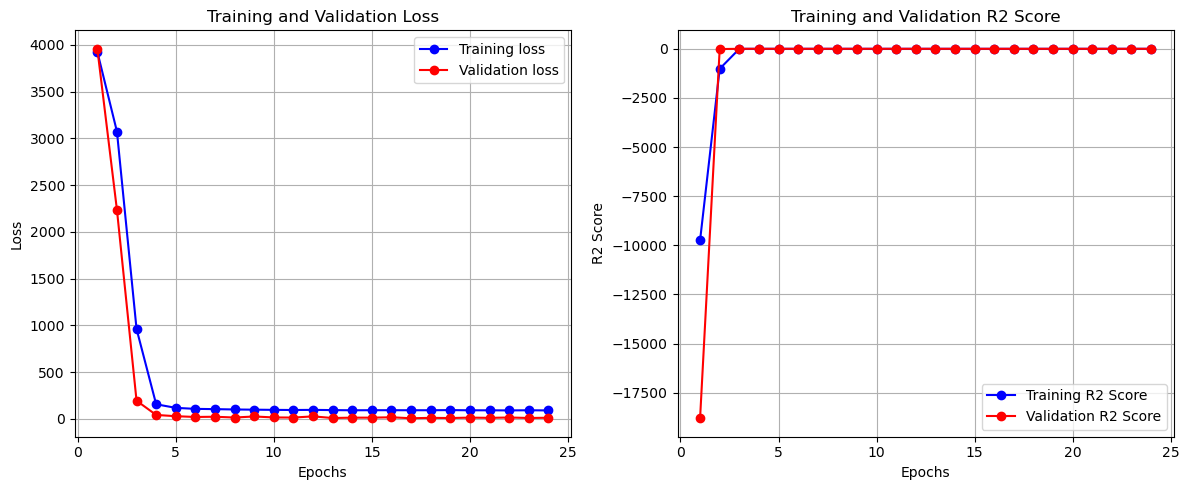


Testing Best Regression Model...
------------------------------------------------------------
Starting Testing...
------------------------------------------------------------


[Test] :   0%|          | 0/157 [00:00<?, ?it/s]

------------------------------------------------------------
Test Results:
  Test Loss: 14.1214
  Test R2 Score: 0.9871
------------------------------------------------------------


(14.121379061986534, 0.9871320019593226)

In [30]:
# ==================================================
# 2.2 Модель для Мультирегрессии
# ==================================================
print("\n" + "=" * 5 + " Task 1: Multiregression " + "=" * 5)

# --- Данные для регрессии ---
print("Generating regression data...")
N_REG_SAMPLES = 50000
N_REG_FEATURES = 10
N_REG_TARGETS = 3  # Мультирегрессия

# Создаем случайную матрицу весов и смещение
W_true = np.random.randn(N_REG_TARGETS, N_REG_FEATURES).astype(np.float32) * 2
b_true = np.random.randn(N_REG_TARGETS).astype(np.float32) * 5

X_reg = np.random.rand(N_REG_SAMPLES, N_REG_FEATURES).astype(np.float32) * 10
# Линейная зависимость + шум
y_reg = (
    X_reg @ W_true.T
    + b_true
    + np.random.randn(N_REG_SAMPLES, N_REG_TARGETS).astype(np.float32) * 0.5
).astype(np.float32)

# Стандартизация входных данных (важно для регрессии)
scaler = StandardScaler()
X_reg_scaled = scaler.fit_transform(X_reg)

# Разделение данных
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg_scaled, y_reg, test_size=0.2, random_state=42
)
X_reg_train, X_reg_val, y_reg_train, y_reg_val = train_test_split(
    X_reg_train, y_reg_train, test_size=0.15, random_state=42
)  # 0.8*0.15 ~ 0.12 -> 68/12/20 split
print(
    f"Regression data shapes: Train={X_reg_train.shape}, Val={X_reg_val.shape}, Test={X_reg_test.shape}"
)


# --- Модели для регрессии (FCNN) ---
def create_regression_model(
    n_features, n_targets, hidden_size, n_layers, activation=ReLU, dropout_p=0.0
):
    model = Sequential()
    last_size = n_features
    for i in range(n_layers):
        model.add(Linear(last_size, hidden_size))
        # Добавляем Batch Norm + Scaling (имитация affine=True)
        model.add(BatchNormalization())  # Alpha по умолчанию
        model.add(ChannelwiseScaling(hidden_size))
        model.add(activation())
        if dropout_p > 0:
            model.add(Dropout(dropout_p))
        last_size = hidden_size
    model.add(Linear(last_size, n_targets))  # Выходной слой без активации для регрессии
    return model


# Маленькая модель
model_reg_small = create_regression_model(
    N_REG_FEATURES,
    N_REG_TARGETS,
    hidden_size=32,
    n_layers=1,
    activation=ReLU,
    dropout_p=0.1,
)
# Средняя модель
model_reg_medium = create_regression_model(
    N_REG_FEATURES,
    N_REG_TARGETS,
    hidden_size=64,
    n_layers=2,
    activation=LeakyReLU,
    dropout_p=0.2,
)
# Большая модель
model_reg_large = create_regression_model(
    N_REG_FEATURES,
    N_REG_TARGETS,
    hidden_size=128,
    n_layers=3,
    activation=Tanh,
    dropout_p=0.3,
)

# --- Обучение и оценка (Пример для средней модели) ---
print("\nTraining Medium Regression Model...")
model_to_train = model_reg_medium
criterion_reg = MSECriterion()
optimizer_reg = Adam(
    model_to_train.getParameters(), learning_rate=1e-3, weight_decay=1e-4
)  # Adam часто лучше для FCNN
scheduler_reg = StepLR(optimizer_reg, step_size=10, gamma=0.5)
# Warmup на 3 эпохи до целевого LR
warmup_reg = WarmupLR(
    optimizer_reg,
    warmup_epochs=3,
    initial_lr=1e-5,
    target_lr=1e-3,
    scheduler_after_warmup=scheduler_reg,
)
early_stopping_reg = EarlyStopping(
    patience=7, verbose=True, path="best_regression_model.pkl"
)

# Запуск обучения
reg_history = train_validate_model(
    model_to_train,
    criterion_reg,
    optimizer_reg,
    scheduler_reg,
    warmup_reg,
    early_stopping_reg,
    X_reg_train,
    y_reg_train,
    X_reg_val,
    y_reg_val,
    epochs=30,
    batch_size=64,
    metric_func=calculate_r2,
    metric_name="R2 Score",
    task_type="regression",
)

# Отрисовка графиков
plot_history(*reg_history, metric_name="R2 Score")

# Тестирование лучшей модели
print("\nTesting Best Regression Model...")
test_model(
    model_to_train,
    criterion_reg,
    X_reg_test,
    y_reg_test,
    batch_size=64,
    metric_func=calculate_r2,
    metric_name="R2 Score",
    task_type="regression",
)

In [31]:
class ClassNLLCriterion(Criterion):  # <-- Наследуемся от вашего Criterion
    def __init__(self):
        super(
            ClassNLLCriterion, self
        ).__init__()  # Вызываем __init__ базового Criterion
        self.log_probs = None
        self.target_indices = None

    def updateOutput(self, log_probabilities, target_indices):
        batch_size = log_probabilities.shape[0]
        self.log_probs = log_probabilities
        self.target_indices = target_indices
        correct_log_probs = log_probabilities[np.arange(batch_size), target_indices]
        self.output = -np.mean(correct_log_probs)
        return self.output

    def updateGradInput(self, log_probabilities, target_indices):
        batch_size, n_classes = log_probabilities.shape
        self.gradInput = np.zeros_like(log_probabilities)
        self.gradInput[np.arange(batch_size), target_indices] = -1.0 / batch_size
        return self.gradInput


# --- MSELoss (наследуется от Criterion) ---
class MSELoss(Criterion):  # <-- Наследуемся от вашего Criterion
    def __init__(self):
        super(MSELoss, self).__init__()  # Вызываем __init__ базового Criterion
        self.diff = None

    def updateOutput(self, y_pred, y_true):
        y_pred_f64 = y_pred.astype(np.float64, copy=False)
        y_true_f64 = y_true.astype(np.float64, copy=False)
        self.diff = y_pred_f64 - y_true_f64
        self.output = np.mean(np.power(self.diff, 2))
        return self.output

    def updateGradInput(self, y_pred, y_true):
        if self.diff is None:
            raise RuntimeError("Need forward pass")
        batch_size = y_pred.shape[0]
        num_elements = y_pred.size
        self.gradInput = 2.0 * self.diff / num_elements
        return self.gradInput.astype(y_pred.dtype)


===== Task 2: MNIST Classification =====
Loading MNIST data...
MNIST data shapes: Train=(51000, 1, 28, 28), Val=(9000, 1, 28, 28), Test=(10000, 1, 28, 28)
Building CNN model for MNIST...
Sequential (
  (0):   Conv2d(1,8,K=(5, 5),S=(1, 1),P=2)
  (1):   ReLU()
  (2):   MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (3):   Conv2d(8,16,K=(3, 3),S=(1, 1),P=1)
  (4):   ReLU()
  (5):   MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (6):   Flatten(start_dim=1, end_dim=-1)
  (7):   Linear(in=784, out=128)
  (8):   ReLU()
  (9):   Dropout(p=0.25)
  (10):   Linear(in=128, out=10)
  (11):   LogSoftMax()
)

Training CNN Model...
------------------------------------------------------------
Starting Training for 1 epochs...
------------------------------------------------------------


Epoch 1/1 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 1/1 [Val]  :   0%|          | 0/71 [00:00<?, ?it/s]

E 1/1 Summary: Train Loss: 0.3297, Val Loss: 0.0980, Train Accuracy: 0.9054, Val Accuracy: 0.9701
  Validation loss decreased (inf --> 0.097956). Saving model ...
------------------------------------------------------------
Training finished.
------------------------------------------------------------
Loading best model from best_cnn_model.pkl with val_loss: 0.097956


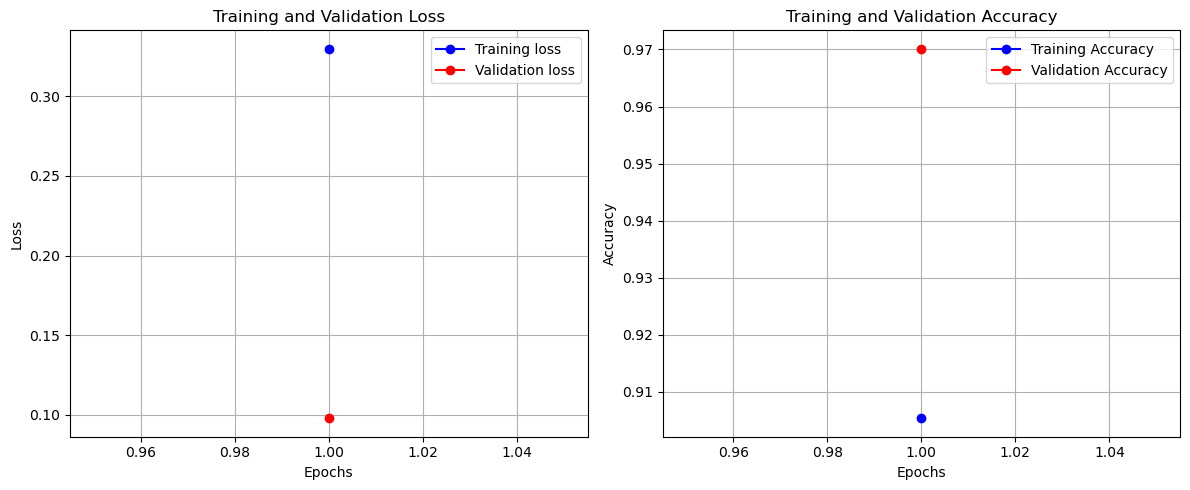


Testing Best CNN Model...
------------------------------------------------------------
Starting Testing...
------------------------------------------------------------


[Test] :   0%|          | 0/79 [00:00<?, ?it/s]

------------------------------------------------------------
Test Results:
  Test Loss: 0.0859
  Test Accuracy: 0.9729
------------------------------------------------------------


In [32]:
# ==================================================
# 2.3 Модель для Мультиклассификации на MNIST
# ==================================================
print("\n" + "=" * 5 + " Task 2: MNIST Classification " + "=" * 5)

# --- Данные MNIST ---
if TORCHVISION_AVAILABLE:
    print("Loading MNIST data...")
    # Загрузка и преобразование в NumPy float32
    mnist_train_val = MNIST(
        root="./data", train=True, download=True, transform=ToTensor()
    )
    mnist_test = MNIST(root="./data", train=False, download=True, transform=ToTensor())

    # Конвертация в NumPy и нормализация [-1, 1] или [0, 1]
    X_mnist = (
        mnist_train_val.data.numpy().astype(np.float32) / 255.0
    )  # Нормализация в [0, 1]
    y_mnist = mnist_train_val.targets.numpy()
    X_test_mnist = mnist_test.data.numpy().astype(np.float32) / 255.0
    y_test_mnist = mnist_test.targets.numpy()

    # Добавляем ось каналов (MNIST черно-белый)
    X_mnist = X_mnist[:, None, :, :]  # (60000, 1, 28, 28)
    X_test_mnist = X_test_mnist[:, None, :, :]  # (10000, 1, 28, 28)

    # Разделение на train/validation
    X_train_mnist, X_val_mnist, y_train_mnist, y_val_mnist = train_test_split(
        X_mnist,
        y_mnist,
        test_size=0.15,
        random_state=42,
        stratify=y_mnist,  # Stratify важно для классификации
    )
    print(
        f"MNIST data shapes: Train={X_train_mnist.shape}, Val={X_val_mnist.shape}, Test={X_test_mnist.shape}"
    )

    # --- Модель CNN для MNIST ---
    print("Building CNN model for MNIST...")
    model_cnn = Sequential()
    # Input: (N, 1, 28, 28)
    model_cnn.add(
        Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=2)
    )  # (N, 8, 28, 28) padding='same' effect
    model_cnn.add(ReLU())
    model_cnn.add(MaxPool2d(kernel_size=2, stride=2))  # (N, 8, 14, 14)
    # ----
    model_cnn.add(
        Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
    )  # (N, 16, 14, 14)
    model_cnn.add(ReLU())
    model_cnn.add(MaxPool2d(kernel_size=2, stride=2))  # (N, 16, 7, 7)
    # ----
    model_cnn.add(Flatten())  # (N, 16 * 7 * 7 = 784)
    model_cnn.add(Linear(n_in=16 * 7 * 7, n_out=128))
    model_cnn.add(ReLU())
    model_cnn.add(Dropout(0.25))  # Dropout перед финальным слоем
    model_cnn.add(Linear(n_in=128, n_out=10))  # 10 классов MNIST
    model_cnn.add(LogSoftMax())  # Для ClassNLLCriterion
    print(model_cnn)

    # --- Обучение CNN ---
    print("\nTraining CNN Model...")
    criterion_cnn = ClassNLLCriterion()
    optimizer_cnn = Adam(
        model_cnn.getParameters(), learning_rate=1e-3
    )  # Adam часто хорош для CNN
    # Можно добавить scheduler и warmup, но для примера пропустим
    # scheduler_cnn = StepLR(optimizer_cnn, step_size=5, gamma=0.5)
    # warmup_cnn = WarmupLR(optimizer_cnn, 3, 1e-5, 1e-3, scheduler_cnn)
    early_stopping_cnn = EarlyStopping(
        patience=5, verbose=True, path="best_cnn_model.pkl"
    )

    cnn_history = train_validate_model(
        model_cnn,
        criterion_cnn,
        optimizer_cnn,
        scheduler=None,
        warmup_scheduler=None,
        early_stopping=early_stopping_cnn,
        X_train=X_train_mnist,
        y_train=y_train_mnist,
        X_val=X_val_mnist,
        y_val=y_val_mnist,
        epochs=1,
        batch_size=128,  # Увеличим batch_size для MNIST
        metric_func=calculate_accuracy,
        metric_name="Accuracy",
        task_type="classification",
    )

    # Отрисовка графиков
    plot_history(*cnn_history, metric_name="Accuracy")

    # Тестирование
    print("\nTesting Best CNN Model...")
    test_model(
        model_cnn,
        criterion_cnn,
        X_test_mnist,
        y_test_mnist,
        batch_size=128,
        metric_func=calculate_accuracy,
        metric_name="Accuracy",
        task_type="classification",
    )

else:
    print("Skipping MNIST task as torchvision is not available.")

In [33]:
class Upsample(Module):
    def __init__(self, scale_factor=2):
        super(Upsample, self).__init__()
        self.scale_factor = scale_factor
        self.input_shape = None

    def updateOutput(self, input):
        self.input_shape = input.shape
        N, C, H, W = input.shape
        H_out = H * self.scale_factor
        W_out = W * self.scale_factor
        # Простое повторение строк и столбцов
        self.output = input.repeat(self.scale_factor, axis=2).repeat(
            self.scale_factor, axis=3
        )
        return self.output

    def updateGradInput(self, input, gradOutput):
        # Градиент нужно "сложить" из соответствующих пикселей gradOutput
        N, C, H_out, W_out = gradOutput.shape
        H_in = H_out // self.scale_factor
        W_in = W_out // self.scale_factor
        # Решейпим gradOutput и суммируем по блокам scale_factor x scale_factor
        # (N, C, H_in, sf, W_in, sf) -> sum over sf axes (3, 5)
        gradOutput_reshaped = gradOutput.reshape(
            N, C, H_in, self.scale_factor, W_in, self.scale_factor
        )
        self.gradInput = gradOutput_reshaped.sum(axis=(3, 5))
        return self.gradInput

    def __repr__(self):
        return f"Upsample(scale={self.scale_factor})"


===== Task 3: Autoencoder =====
Using MNIST data for Autoencoder...
Building Autoencoder model...
Sequential (
  (0):   Sequential (
    (0):   Conv2d(1,16,K=(3, 3),S=(2, 2),P=1)
    (1):   ReLU()
    (2):   Conv2d(16,32,K=(3, 3),S=(2, 2),P=1)
  )
  (1):   Sequential (
    (0):   Upsample(scale=2)
    (1):   Conv2d(32,16,K=(3, 3),S=(1, 1),P=1)
    (2):   ReLU()
    (3):   Upsample(scale=2)
    (4):   Conv2d(16,1,K=(3, 3),S=(1, 1),P=1)
    (5):   Sigmoid()
  )
)

Training Autoencoder Model...
------------------------------------------------------------
Starting Training for 1 epochs...
------------------------------------------------------------


Epoch 1/1 [Train]:   0%|          | 0/399 [00:00<?, ?it/s]

Epoch 1/1 [Val]  :   0%|          | 0/71 [00:00<?, ?it/s]

E 1/1 Summary: Train Loss: 0.0208, Val Loss: 0.0056
  Validation loss decreased (inf --> 0.005639). Saving model ...
------------------------------------------------------------
Training finished.
------------------------------------------------------------
Loading best model from best_autoencoder_model.pkl with val_loss: 0.005639


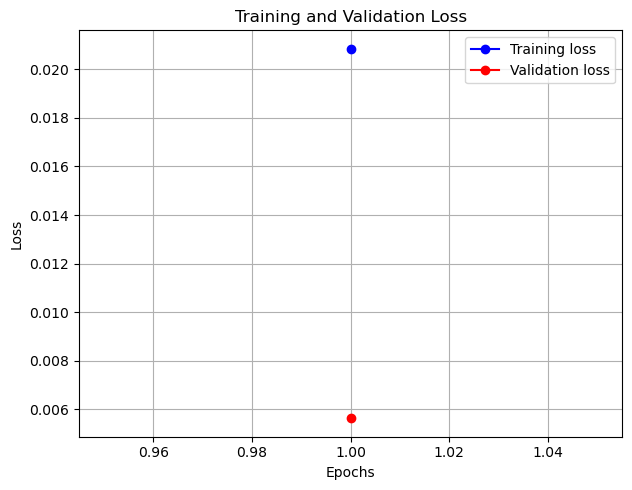


Testing Best Autoencoder Model...
------------------------------------------------------------
Starting Testing...
------------------------------------------------------------


[Test] :   0%|          | 0/79 [00:00<?, ?it/s]

------------------------------------------------------------
Test Results:
  Test Loss: 0.0054
------------------------------------------------------------


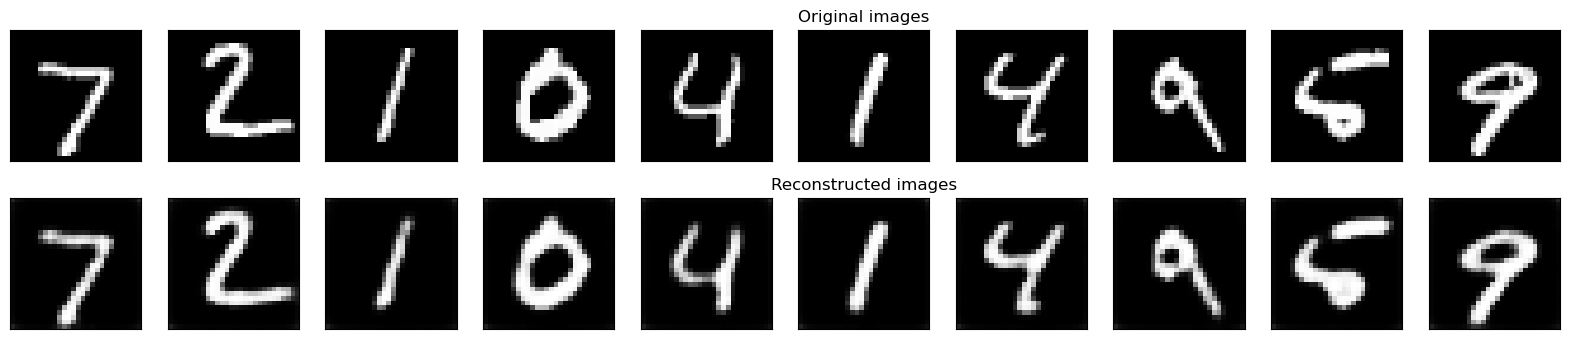


All tasks finished.


In [34]:
# ==================================================
# 2.4 Автоэнкодер
# ==================================================
print("\n" + "=" * 5 + " Task 3: Autoencoder " + "=" * 5)

# --- Данные для автоэнкодера (можно использовать MNIST или создать свои) ---
# Используем MNIST X_train_mnist, X_val_mnist, X_test_mnist
# Цель - восстановить вход, поэтому y = X
if TORCHVISION_AVAILABLE:
    print("Using MNIST data for Autoencoder...")
    X_ae_train, X_ae_val = X_train_mnist, X_val_mnist  # Не y, а сам X
    X_ae_test = X_test_mnist

    # --- Модель Автоэнкодера (Свёрточный) ---
    print("Building Autoencoder model...")
    encoder = Sequential()
    # Input: (N, 1, 28, 28)
    encoder.add(Conv2d(1, 8, 3, stride=2, padding=1))  # -> (N, 8, 14, 14)
    encoder.add(ReLU())
    encoder.add(Conv2d(8, 16, 3, stride=2, padding=1))  # -> (N, 16, 7, 7)
    encoder.add(ReLU())
    encoder.add(
        Conv2d(16, 32, 3, stride=2, padding=1)
    )  # -> (N, 32, 4, 4) - Латентное пр-во до Flatten
    # Можно добавить Flatten + Linear для получения вектора
    # encoder.add(Flatten())
    # encoder.add(Linear(32*4*4, latent_dim))

    decoder = Sequential()
    # Нужно иметь ConvTranspose или использовать Upsample + Conv
    # Decoder (Upsample + Conv)
    # Input: (N, 32, 4, 4)
    decoder.add(Upsample(scale_factor=2))  # -> (N, 32, 8, 8)
    decoder.add(
        Conv2d(32, 16, 3, padding=1)
    )  # -> (N, 16, 8, 8) # padding=1 для сохранения размера
    decoder.add(ReLU())
    decoder.add(Upsample(scale_factor=2))  # -> (N, 16, 16, 16)
    decoder.add(Conv2d(16, 8, 3, padding=1))  # -> (N, 8, 16, 16)
    decoder.add(ReLU())
    decoder.add(Upsample(scale_factor=2))  # -> (N, 8, 32, 32)
    decoder.add(Conv2d(8, 1, 3, padding=1))  # -> (N, 1, 32, 32)
    # Нужно обрезать до 28x28 или изменить архитектуру
    # Проще изменить архитектуру энкодера/декодера
    # Давайте сделаем симметричнее:
    encoder = Sequential()
    # Input: (N, 1, 28, 28)
    encoder.add(Conv2d(1, 16, 3, stride=2, padding=1))  # (N, 16, 14, 14)
    encoder.add(ReLU())
    encoder.add(Conv2d(16, 32, 3, stride=2, padding=1))  # (N, 32, 7, 7) - Latent

    decoder = Sequential()
    # Input: (N, 32, 7, 7)
    decoder.add(Upsample(scale_factor=2))  # (N, 32, 14, 14)
    decoder.add(Conv2d(32, 16, 3, padding=1))  # (N, 16, 14, 14)
    decoder.add(ReLU())
    decoder.add(Upsample(scale_factor=2))  # (N, 16, 28, 28)
    decoder.add(Conv2d(16, 1, 3, padding=1))  # (N, 1, 28, 28)
    decoder.add(Sigmoid())  # Выход в [0, 1], как и входные данные MNIST

    # Собираем автоэнкодер
    autoencoder = Sequential()
    autoencoder.add(encoder)
    autoencoder.add(decoder)
    print(autoencoder)

    # --- Обучение Автоэнкодера ---
    print("\nTraining Autoencoder Model...")
    criterion_ae = MSELoss()  # Восстанавливаем изображение - MSE
    optimizer_ae = Adam(autoencoder.getParameters(), learning_rate=1e-3)
    # Оставим без шедулера/вормапа для простоты
    early_stopping_ae = EarlyStopping(
        patience=5, verbose=True, path="best_autoencoder_model.pkl"
    )

    # Обучаем: ВАЖНО - y_train это X_train для автоэнкодера
    ae_history = train_validate_model(
        autoencoder,
        criterion_ae,
        optimizer_ae,
        scheduler=None,
        warmup_scheduler=None,
        early_stopping=early_stopping_ae,
        X_train=X_ae_train,
        y_train=X_ae_train,
        X_val=X_ae_val,
        y_val=X_ae_val,  # y = X
        epochs=1,
        batch_size=128,
        metric_func=None,  # Метрика не нужна, смотрим на loss
        task_type="regression",  # Используем для корректной обработки y=X
    )

    # Отрисовка графиков потерь
    plot_history(ae_history[0], ae_history[1])  # Только лоссы

    # Тестирование и визуализация
    print("\nTesting Best Autoencoder Model...")
    test_loss_ae, _ = test_model(
        autoencoder,
        criterion_ae,
        X_ae_test,
        X_ae_test,
        batch_size=128,
        task_type="regression",
    )

    # Визуализация результатов
    n_images_to_show = 10
    autoencoder.evaluate()
    test_output = autoencoder.forward(X_ae_test[:n_images_to_show])

    plt.figure(figsize=(20, 4))
    for i in range(n_images_to_show):
        # original
        ax = plt.subplot(2, n_images_to_show, i + 1)
        plt.imshow(X_ae_test[i].reshape(28, 28), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n_images_to_show // 2:
            ax.set_title("Original images")

        # reconstruction
        ax = plt.subplot(2, n_images_to_show, i + 1 + n_images_to_show)
        plt.imshow(test_output[i].reshape(28, 28), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n_images_to_show // 2:
            ax.set_title("Reconstructed images")
    plt.show()

else:
    print("Skipping Autoencoder task as MNIST data is not available.")

# ==================================================
# Конец скрипта
# ==================================================
print("\nAll tasks finished.")